# FTE Analysis, SY 2020-2021
This notebook captures an analysis of time worked, specifically bulk effort in relation to FTE. The first section of this notebook cleans the data. Click through to skip to the [data analysis](#data_analysis).

In [1]:
import pygsheets
import pandas as pd
import numpy as np
from datetime import datetime as dt
import os
import sys
import json

In [2]:
def auth_gspread():
    """Authorize Google to access the Utilization Project"""
    # creds for local development
    try:
        client = pygsheets.authorize(
            service_file='../secrets/gs_credentials_OLD.json'
            )
    # creds for heroku deployment
    except:
        client = pygsheets.authorize(
            service_account_env_var='GOOGLE_SHEETS_CREDS_JSON'
        )
        
    return client

In [3]:
def load_report(client, spreadsheet, sheet_title):
    """Load data (must be in tidy format) from sheet.
    Empty rows are dropped.
    :param client: client object for accessing google
    :param sheet_title: sheet name
    :returns pandas dataframe
    """
    # load data from google sheet
    sh = client.open(spreadsheet)
    wks = sh.worksheet_by_title(sheet_title)
    data = wks.get_all_records(empty_value=None)  # get_as_df can't handle empty columns
    df = pd.DataFrame(data)
    df.dropna(axis=0, how='all', inplace=True)
    
    return df

In [4]:
def all_hours(client):
    """Combine Replicon and Cognos hours reports
    :param client: client object for accessing google
    :returns: dataframe of hours x person x day
    """
    print('Loading utilization data from Utilization-Hours')
    # load 2019 hours
    df2019 = load_report(client, 'Utilization-Hours', 'hours-2019')
    
    # load 2020 apr - may hours
    df2020_1 = load_report(client, 'Utilization-Hours','apr-may-2020')

    # load jun 2020 + hours
    df2020_2 = load_report(client, 'Utilization-Hours','june-mar-2020')
    
    # union all 
    print('Combining and formatting data')
    df = pd.concat([df2019, df2020_1, df2020_2])
    
    # set dtypes
    df['Hours Date'] = pd.to_datetime(df['Hours Date'])
    df['Entered Hours'] = pd.to_numeric(df['Entered Hours'])
    df['Approved Hours'] = pd.to_numeric(df['Approved Hours'])
    df['Entry Year'] = pd.to_numeric(df['Entry Year'])
    
    # reclass unbillable to R&D
    filt = df['Task Name'].str.contains('Unbillable', na=False)
    df.loc[filt, 'Classification'] = 'R&D'
    
    return df

In [5]:
# Authorize google sheets
client = auth_gspread()
hours_report = all_hours(client)

Loading utilization data from Utilization-Hours
Combining and formatting data


In [6]:
hours_report.head()

,Employee ID,Work Schedule Description,Org Name,Task ID,Task Name,User Defined Code 3,Hours Date,Entered Hours,Approved Hours,Comments,Entry Month,Entry Year,User Name,Classification,Project
0,None,Standard,Company Health,None,HR & Recruiting (Int'l),OVH,2019-04-08,7.0,0,None,Apr,2019,"Abragan, Maria Celes",Overhead,None
1,None,Standard,Company Health,None,General (Int'l),G&A,2019-04-09,2.0,0,None,Apr,2019,"Abragan, Maria Celes",G&A,None
2,None,Standard,Company Health,None,HR & Recruiting (Int'l),OVH,2019-04-09,3.0,0,None,Apr,2019,"Abragan, Maria Celes",Overhead,None
3,None,Standard,Company Health,None,Planning and Ops (Int'l),G&A,2019-04-09,3.0,0,None,Apr,2019,"Abragan, Maria Celes",G&A,None
4,None,Standard,Company Health,None,General (Int'l),G&A,2019-04-10,2.0,0,None,Apr,2019,"Abragan, Maria Celes",G&A,None


In [16]:
hours_report['week'] = hours_report['Hours Date'].dt.isocalendar().week
filt = hours_report['Classification'] == 'Billable'
weekly_hours = hours_report.loc[filt].groupby(['User Name','Entry Year', 'week'])['Entered Hours'].sum()
filt = weekly_hours>40
weeks_over_hours = weekly_hours.loc[filt] - 40
weeks_over_hours = pd.DataFrame(weeks_over_hours).reset_index()
weeks_over_hours.head()

,User Name,Entry Year,week,Entered Hours
0,"Abragan, Maria Celes",2020,32,2.32
1,"Ajroud, Brittany",2019,20,2.25
2,"Ajroud, Brittany",2019,21,5.50
3,"Ajroud, Brittany",2019,28,13.00
4,"Ajroud, Brittany",2019,32,1.00


In [33]:
filt = weeks_over_hours['User Name'].isin(['Srikanth, Sushmita', 'Byenkya, Tina'])
weeks_over_hours = weeks_over_hours.loc[~filt]

<AxesSubplot:>

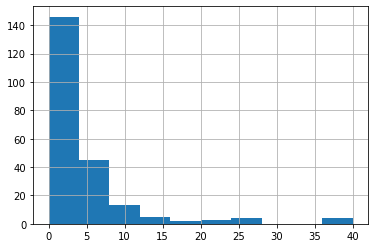

In [34]:
weeks_over_hours['Entered Hours'].hist()

In [35]:
weeks_over_hours.head()

,User Name,Entry Year,week,Entered Hours
0,"Abragan, Maria Celes",2020,32,2.32
1,"Ajroud, Brittany",2019,20,2.25
2,"Ajroud, Brittany",2019,21,5.50
3,"Ajroud, Brittany",2019,28,13.00
4,"Ajroud, Brittany",2019,32,1.00


In [37]:
weeks_over_hours = weeks_over_hours.sort_values(by=['Entered Hours'], ascending=False)
weeks_over_hours.head()

,User Name,Entry Year,week,Entered Hours
15,"Ballard, Elisa",2020,45,40.00
226,"Spencer, Richard",2020,28,40.00
18,"Ballard, Elisa",2020,50,40.00
16,"Ballard, Elisa",2020,46,40.00
158,"Motlow, Mary-Sophia",2019,46,27.75


In [39]:
len(weeks_over_hours)

222

In [38]:
weeks_over_hours.groupby('Entry Year')['Entered Hours'].sum()

Entry Year
2019    412.23
2020    581.53
2021     88.84
Name: Entered Hours, dtype: float64

In [7]:
def get_latest_file(downloads, file_name):
    # list all files in downloads
    all_files = [f for f in os.listdir(downloads) 
                 if f.startswith(file_name)]
    # get save times
    file_versions = [os.path.getmtime(os.path.join(downloads, f)) 
                     for f in all_files]
    # access file with most recent save time
    latest_file = [f for f in all_files 
                   if os.path.getmtime(os.path.join(downloads, f)) 
                   == max(file_versions)]
    
    latest_file = os.path.join(downloads, latest_file[0])
    print(latest_file)
    
    return latest_file

In [8]:
# Download folder where hours report will be saved from Deltek
downloads = r'C:/Users/Erik/Downloads/'
# Name of the file, excluding any appended numeric distinguisher for repeats
employees_file = 'Employees Work Schedule'
# read it in
employees_in = get_latest_file(downloads, employees_file)
emp_df = pd.read_csv(employees_in, sep='\t',
                   encoding='utf_16_le')
emp_df['Hire date'] = pd.to_datetime(emp_df['Hire date'])
emp_df['Termination date'] = pd.to_datetime(emp_df['Termination date'])
emp_df['Effective Date'] = pd.to_datetime(emp_df['Effective Date'])
emp_df['User Name'] = emp_df['Last Name'] + ', ' + emp_df['First Name']
emp_df.head()

C:/Users/Erik/Downloads/Employees Work Schedule (1).csv


,Employee ID,Last Name,First Name,Hire date,Termination date,Work Schedule,Effective Date,User Name
0,100001,Alexandrovich,Andrew,2010-04-05,NaT,STD,2010-04-05,"Alexandrovich, Andrew"
1,100002,Christen,Ellen,2015-09-21,2019-02-01,NaN,NaT,"Christen, Ellen"
2,100003,Ajroud,Brittany,2016-10-18,NaT,STD,2016-10-18,"Ajroud, Brittany"
3,100003,Ajroud,Brittany,2016-10-18,NaT,STD,2020-12-01,"Ajroud, Brittany"
4,100004,Chandrasekaran,Chetna,2017-07-17,NaT,STD,2017-07-17,"Chandrasekaran, Chetna"


In [9]:
# During initial data exploration, an employee was
# found to have worked a week after their termination
# date. We'll update the termination date to match.
filt = emp_df['Employee ID'] == 100094 
emp_df.loc[filt, 'Termination date'] = pd.to_datetime('2020-11-30')
emp_df.loc[filt]

,Employee ID,Last Name,First Name,Hire date,Termination date,Work Schedule,Effective Date,User Name
98,100094,Peimbert,Nadia,2020-09-01,2020-11-30,STD,2020-09-01,"Peimbert, Nadia"


In [13]:
# let's make sure the Employee ID field is valid for using as our employee identifier
hours_report['Employee ID'].unique()

array([None, 100041, 100003, 100001, 100022, 100063, 100023, 100067,
       100004, 100045, 100039, 100005, 100076, 100007, 100043, 100008,
       100009, 100010, 100065, 100034, 100033, 100012, 100013, 100014,
       100044, 100015, 100064, 100074, 100025, 100016, 100069, 100017,
       100030, 100018, 100026, 100020, 100047, 100029, '#N/A', 100042,
       100073, 100091, 100093, 100095, 100101, 100110, 100090, 100092,
       100096, 100075, 100078, 100080, 100085, 100086, 100087, 100088,
       100089, 100094, 100079, 100082, 100102, 100103, 100106, 100107,
       100084, 100038, 100077, 100081, 100083, 100097, 100098, 100099,
       100100, 100104, 100105, 100111, 100109], dtype=object)

In [14]:
hours_report[hours_report['Employee ID'] == '#N/A']['User Name'].unique()

array(['Stiger, Rachel (rstiger)'], dtype=object)

In [15]:
# resolve Employee ID for Replicon time entries
emp_id_dict = emp_df[emp_df['Employee ID'].notnull()]\
    .groupby('User Name')['Employee ID'].first()\
    .to_dict()
hours_report['Employee ID'] = hours_report['User Name'].map(emp_id_dict)
# The employees printed below were not resolved... 
hours_report[hours_report['Employee ID'].isnull()]['User Name'].unique()

array(['Gutierrez, Eileen (egutierrez)', 'Stiger, Rachel (rstiger)'],
      dtype=object)

In [16]:
emp_id_dict

{'Abragan, Maria Celes': 100041,
 'Ajroud, Brittany': 100003,
 'Alexandrovich, Andrew': 100001,
 'Anderson, Erik': 100022,
 'Armanino, Molly': 100027,
 'Baca, Jennifer': 100063,
 'Ballard, Elisa': 100083,
 'Bevins, Melissa': 100079,
 'Boutemy, Gabrielle': 100084,
 'Boyle, Anne': 100110,
 'Boysen, Kristen': 100023,
 'Brickman, Josh': 100107,
 'Brock, Cameryn': 100038,
 'Byenkya, Tina': 100097,
 'Castillo Ferri, Mauricio': 100067,
 'Chandrasekaran, Chetna': 100004,
 'Chery, Megan': 100045,
 'Chesterman, Nathan': 100039,
 'Christen, Ellen': 100002,
 'Cohenca, Yair': 100106,
 'Connolly, Katherine': 100092,
 'Cook, Caroline': 100005,
 'Core, Lauren': 100108,
 'Daniels, Molly': 100076,
 'Doherty, Eoin': 100024,
 'Doyle, Katherine': 100103,
 'Dubois, Natalie': 100007,
 'Durand, Eleonore': 100077,
 'Exline, Kelly': 100043,
 'Flower, Kathleen': 100008,
 'Fong, Regina': 100091,
 'Gambrill, Amy': 100009,
 'Giannoni, Tonya': 100086,
 'Gibert, Tiffany': 100010,
 'Golden, Renae': 100028,
 'Grange, S

In [17]:
# ...names with parens are causing an issue, replace
custom_dict = {'Gutierrez, Eileen (egutierrez)': 100011,
              'Stiger, Rachel (rstiger)': 100070}
for name, eid in custom_dict.items():
    filt = hours_report['User Name'] == name
    hours_report.loc[filt, 'Employee ID'] = eid
hours_report[hours_report['Employee ID'].isnull()]['User Name'].unique()

array([], dtype=object)

In [18]:
# During initial data exploration, a holiday was discovered 
# assigned to an employee after their termination date,
# we need to delete it.
filt = (hours_report['Employee ID']==100027) & (hours_report['Hours Date'] == pd.to_datetime('2019-12-25'))
hours_report = hours_report.loc[~filt]

In [19]:
# During initial data exploration, an employee had logged
# hours before their hire date, suggesting they worked
# during two periods. We'll delete this person for
# this analysis (but consider adding an employee replicate
# if the right employment dates can be discovered)
filt = hours_report['Employee ID'] == 100038
hours_report = hours_report.loc[~filt]

In [20]:
first_valid_date = '2019-04-01'
last_valid_date = '2021-01-31'

start = pd.to_datetime(first_valid_date)
end = pd.to_datetime(last_valid_date)

filt = (hours_report['Hours Date'] >= start) & (hours_report['Hours Date'] <= end)
hours_report = hours_report.loc[filt]

In [22]:
hours_report['User Name'].unique()

array(['Abragan, Maria Celes', 'Ajroud, Brittany',
       'Alexandrovich, Andrew', 'Anderson, Erik', 'Armanino, Molly',
       'Baca, Jennifer', 'Boysen, Kristen', 'Castillo Ferri, Mauricio',
       'Chandrasekaran, Chetna', 'Chery, Megan', 'Chesterman, Nathan',
       'Cook, Caroline', 'Doherty, Eoin', 'Dubois, Natalie',
       'Exline, Kelly', 'Flower, Kathleen', 'Gambrill, Amy',
       'Gibert, Tiffany', 'Golden, Renae', 'Grange, Sara',
       'Guetschow, Teal', 'Gutierrez, Eileen (egutierrez)',
       'Hansen, Lexine', 'Hardeman, Stephan', 'Hicks, Christine',
       'Homer, Camryn', 'Hoye, Susan', 'King, Elma', 'Lauck, Elizabeth',
       'Martinez-Sanchez, Juan Carlos', 'Merten, Jacob',
       'Motlow, Mary-Sophia', 'Nease, Patrick', 'Nico, Linda',
       'Orti, Leticia', 'Peabody, Shawn', 'Praul, Chad',
       'Present, Teresa', 'Price, Patricia', 'Riley, Kathryn',
       'Schueler, Kelsey', 'Shay, Arica', 'Sokulsky, Jeremy',
       'Stiger, Rachel (rstiger)', 'Uhl, Laura', 'Wells

In [23]:
# get fte hours
fte_df = emp_df[['Employee ID', 'Last Name', 'First Name', 'Work Schedule', 'Hire date', 'Termination date', 'Effective Date']].copy()

In [24]:
# Do any employees lack a work schedule?
fte_df[fte_df['Work Schedule'].isnull()]

,Employee ID,Last Name,First Name,Work Schedule,Hire date,Termination date,Effective Date
1,100002,Christen,Ellen,NaN,2015-09-21,2019-02-01,NaT
15,100011,Gutierrez,Eileen,NaN,2018-08-28,2019-04-13,NaT
26,100019,Price,Patricia,NaN,2013-06-25,2019-08-24,NaT
33,100024,Doherty,Eoin,NaN,2010-02-08,2019-06-22,NaT
37,100027,Armanino,Molly,NaN,2017-06-18,2019-12-14,NaT
38,100028,Golden,Renae,NaN,2017-01-30,2019-09-07,NaT
53,100056,Merten,Jacob,NaN,2019-08-06,2020-02-15,NaT
54,100057,Wells,Milena,NaN,2019-08-07,2019-08-30,NaT
55,100061,Homer,Camryn,NaN,2019-09-03,2020-02-15,NaT
56,100062,Orti,Leticia,NaN,2019-09-23,2020-03-15,NaT


In [25]:
# we can safely drop any employees who were terminated before SY 20
filt = (fte_df['Termination date'] >= start) | (fte_df['Termination date'].isnull())
fte_df = fte_df.loc[filt]
fte_df

,Employee ID,Last Name,First Name,Work Schedule,Hire date,Termination date,Effective Date
0,100001,Alexandrovich,Andrew,STD,2010-04-05,NaT,2010-04-05
2,100003,Ajroud,Brittany,STD,2016-10-18,NaT,2016-10-18
3,100003,Ajroud,Brittany,STD,2016-10-18,NaT,2020-12-01
4,100004,Chandrasekaran,Chetna,STD,2017-07-17,NaT,2017-07-17
5,100005,Cook,Caroline,80,2014-07-07,NaT,2014-07-07
...,...,...,...,...,...,...,...
116,100110,Boyle,Anne,STD,2021-01-26,NaT,2021-01-26
117,100111,Pinto,Paola,STD,2021-02-09,NaT,2021-02-09
118,99997,Mosby,Celeste,STD,1901-01-01,NaT,1901-01-01
119,99998,TEST,EMPLOYEE,STD,1901-01-01,NaT,1901-01-01


In [26]:
fte_df[fte_df['Work Schedule'].isnull()]

,Employee ID,Last Name,First Name,Work Schedule,Hire date,Termination date,Effective Date
15,100011,Gutierrez,Eileen,NaN,2018-08-28,2019-04-13,NaT
26,100019,Price,Patricia,NaN,2013-06-25,2019-08-24,NaT
33,100024,Doherty,Eoin,NaN,2010-02-08,2019-06-22,NaT
37,100027,Armanino,Molly,NaN,2017-06-18,2019-12-14,NaT
38,100028,Golden,Renae,NaN,2017-01-30,2019-09-07,NaT
53,100056,Merten,Jacob,NaN,2019-08-06,2020-02-15,NaT
54,100057,Wells,Milena,NaN,2019-08-07,2019-08-30,NaT
55,100061,Homer,Camryn,NaN,2019-09-03,2020-02-15,NaT
56,100062,Orti,Leticia,NaN,2019-09-23,2020-03-15,NaT


In [27]:
# first, let's update the effective date to the hire date
filt = fte_df['Work Schedule'].isnull()
fte_df.loc[filt, 'Effective Date'] = fte_df.loc[filt, 'Hire date']
fte_df.loc[filt]

,Employee ID,Last Name,First Name,Work Schedule,Hire date,Termination date,Effective Date
15,100011,Gutierrez,Eileen,NaN,2018-08-28,2019-04-13,2018-08-28
26,100019,Price,Patricia,NaN,2013-06-25,2019-08-24,2013-06-25
33,100024,Doherty,Eoin,NaN,2010-02-08,2019-06-22,2010-02-08
37,100027,Armanino,Molly,NaN,2017-06-18,2019-12-14,2017-06-18
38,100028,Golden,Renae,NaN,2017-01-30,2019-09-07,2017-01-30
53,100056,Merten,Jacob,NaN,2019-08-06,2020-02-15,2019-08-06
54,100057,Wells,Milena,NaN,2019-08-07,2019-08-30,2019-08-07
55,100061,Homer,Camryn,NaN,2019-09-03,2020-02-15,2019-09-03
56,100062,Orti,Leticia,NaN,2019-09-23,2020-03-15,2019-09-23


In [28]:
# next we must decide what to do with each remaining employee without a work schedule
# let's see how many hours they worked per month relative to the typical 173
# note the last month is unreliable
missing_emps = fte_df[fte_df['Work Schedule'].isnull()]['Employee ID'].unique()
hours_report.loc[hours_report['Employee ID'].isin(missing_emps)].groupby(['Employee ID', 'Entry Month', 'Entry Year'])['Entered Hours'].sum()/173

Employee ID  Entry Month  Entry Year
100011.0     Apr          2019          0.416185
100019.0     Apr          2019          0.508671
             Aug          2019          0.289017
             Jul          2019          0.531792
             Jun          2019          0.462428
             May          2019          0.510116
100024.0     Apr          2019          1.027225
             Jun          2019          0.742601
             May          2019          1.063815
100027.0     Apr          2019          1.105318
             Aug          2019          1.116936
             Dec          2019          0.498555
             Jul          2019          1.140636
             Jun          2019          0.999711
             May          2019          1.308671
             Nov          2019          1.053468
             Oct          2019          1.095665
             Sep          2019          1.039017
100028.0     Apr          2019          1.064624
             Aug          2019  

In [29]:
# update work schedule where known
missing_emp_dict = {
    100011: 'STD',
    100019: '50',
    100024: 'STD',
    100027: 'STD',
    100028: 'STD',
    100056: 'STD',
    100062: 'STD'
}

# part time hourly variable (in reality worked about 45% each according to AS) 
drop = [100057.0, 100061.0]

# update work schedule for known employees
filt = fte_df['Employee ID'].isin(missing_emp_dict.keys())
fte_df.loc[filt, 'Work Schedule'] = fte_df.loc[filt, 'Employee ID'].map(missing_emp_dict)

# drop unknown employees from fte and hours_report
filt = fte_df['Employee ID'].isin(drop)
fte_df = fte_df[~filt]

filt = hours_report['Employee ID'].isin(drop)
hours_report = hours_report[~filt]

In [30]:
fte_df

,Employee ID,Last Name,First Name,Work Schedule,Hire date,Termination date,Effective Date
0,100001,Alexandrovich,Andrew,STD,2010-04-05,NaT,2010-04-05
2,100003,Ajroud,Brittany,STD,2016-10-18,NaT,2016-10-18
3,100003,Ajroud,Brittany,STD,2016-10-18,NaT,2020-12-01
4,100004,Chandrasekaran,Chetna,STD,2017-07-17,NaT,2017-07-17
5,100005,Cook,Caroline,80,2014-07-07,NaT,2014-07-07
...,...,...,...,...,...,...,...
116,100110,Boyle,Anne,STD,2021-01-26,NaT,2021-01-26
117,100111,Pinto,Paola,STD,2021-02-09,NaT,2021-02-09
118,99997,Mosby,Celeste,STD,1901-01-01,NaT,1901-01-01
119,99998,TEST,EMPLOYEE,STD,1901-01-01,NaT,1901-01-01


In [31]:
# We want to be able to analyze at the day level, so we'll create a dataframe
# that has the work schedule for each person on each day.

# We'll use the 'Effective date' column to forward fill (ffill) from the 
# latest effective date. We want the last day in the dataframe to be
# the last_valid_date, so we'll add the day after as an 'Effective date' for 
# each employee so that we fill up to it, and then delete it afterwards, 
# subbing the termination date for any employees who were terminated

# create new df with all employees and provide effective date
last_valid_df = pd.DataFrame(columns = fte_df.columns)
last_valid_df['Employee ID'] = fte_df['Employee ID'].unique()
last_valid_df['Effective Date'] = end + pd.Timedelta(days=1)
last_valid_df.head()

,Employee ID,Last Name,First Name,Work Schedule,Hire date,Termination date,Effective Date
0,100001,NaN,NaN,NaN,NaN,NaN,2021-02-01
1,100003,NaN,NaN,NaN,NaN,NaN,2021-02-01
2,100004,NaN,NaN,NaN,NaN,NaN,2021-02-01
3,100005,NaN,NaN,NaN,NaN,NaN,2021-02-01
4,100007,NaN,NaN,NaN,NaN,NaN,2021-02-01


In [32]:
# were any employees terminated that have a work schedule assigned?
fte_df[fte_df['Termination date'].notnull()]

,Employee ID,Last Name,First Name,Work Schedule,Hire date,Termination date,Effective Date
15,100011,Gutierrez,Eileen,STD,2018-08-28,2019-04-13,2018-08-28
23,100016,Nease,Patrick,STD,2018-09-18,2020-10-15,2018-09-18
25,100018,Present,Teresa,75,2014-02-10,2020-09-30,2014-02-10
26,100019,Price,Patricia,50,2013-06-25,2019-08-24,2013-06-25
33,100024,Doherty,Eoin,STD,2010-02-08,2019-06-22,2010-02-08
34,100025,Motlow,Mary-Sophia,STD,2017-03-31,2020-12-15,2017-03-31
37,100027,Armanino,Molly,STD,2017-06-18,2019-12-14,2017-06-18
38,100028,Golden,Renae,STD,2017-01-30,2019-09-07,2017-01-30
45,100038,Brock,Cameryn,STD,2020-06-15,2021-01-02,2020-06-15
48,100042,Uhl,Laura,STD,2019-04-15,2021-01-15,2019-04-15


In [33]:
# join termination date to update if employee was terminated
termination_df = fte_df.groupby('Employee ID').first()['Termination date'].reset_index()
last_valid_df = pd.merge(last_valid_df, termination_df, how='inner', on='Employee ID')

filt = last_valid_df['Termination date_y'].notnull()
last_valid_df.loc[filt, 'Effective Date'] = last_valid_df.loc[filt, 'Termination date_y']
last_valid_df = last_valid_df.drop(['Termination date_y'], axis=1)

last_valid_df = last_valid_df.rename({'Termination date_x': 'Termination date'}, axis=1)
last_valid_df[last_valid_df['Employee ID']==100016]

,Employee ID,Last Name,First Name,Work Schedule,Hire date,Termination date,Effective Date
13,100016,NaN,NaN,NaN,NaN,NaN,2020-10-15


In [34]:
fte_df = pd.concat([fte_df, last_valid_df])
fte_df

,Employee ID,Last Name,First Name,Work Schedule,Hire date,Termination date,Effective Date
0,100001,Alexandrovich,Andrew,STD,2010-04-05,NaT,2010-04-05
2,100003,Ajroud,Brittany,STD,2016-10-18,NaT,2016-10-18
3,100003,Ajroud,Brittany,STD,2016-10-18,NaT,2020-12-01
4,100004,Chandrasekaran,Chetna,STD,2017-07-17,NaT,2017-07-17
5,100005,Cook,Caroline,80,2014-07-07,NaT,2014-07-07
...,...,...,...,...,...,...,...
82,100110,NaN,NaN,NaN,NaT,NaT,2021-02-01
83,100111,NaN,NaN,NaN,NaT,NaT,2021-02-01
84,99997,NaN,NaN,NaN,NaT,NaT,2021-02-01
85,99998,NaN,NaN,NaN,NaT,NaT,2021-02-01


In [35]:
fte_df.groupby('Employee ID').apply(lambda x: x.set_index('Effective Date').resample('d').first())

Employee ID Last Name First Name Work Schedule  \
Employee ID Effective Date                                                   
99997       1901-01-01          99997.0     Mosby    Celeste           STD   
            1901-01-02              NaN      None       None          None   
            1901-01-03              NaN      None       None          None   
            1901-01-04              NaN      None       None          None   
            1901-01-05              NaN      None       None          None   
...                                 ...       ...        ...           ...   
100111      2021-02-05              NaN      None       None          None   
            2021-02-06              NaN      None       None          None   
            2021-02-07              NaN      None       None          None   
            2021-02-08              NaN      None       None          None   
            2021-02-09         100111.0     Pinto      Paola           STD   

                            Hire date Termination date  
Employee ID Effective Date                              
99997       1901-01-01     1901-01-01              NaT  
            1901-01-02            NaT              NaT  
            1901-01-03            NaT              NaT  
            1901-01-04            NaT              NaT  
            1901-01-05            NaT              NaT  
...                               ...              ...  
100111      2021-02-05            NaT              NaT  
            2021-02-06            NaT              NaT  
            2021-02-07            NaT              NaT  
            2021-02-08            NaT              NaT  
            2021-02-09     2021-02-09              NaT  

[199776 rows x 6 columns]

In [36]:
fte_days = fte_df.groupby('Employee ID')\
           .apply(lambda x: x.set_index('Effective Date')\
           .resample('d').first())\
           .ffill()\
           .reset_index(level=1)\
           .reset_index(drop=True)
filt = (fte_days['Effective Date'] >= start) & (fte_days['Effective Date'] <= end)
fte_days = fte_days.loc[filt].copy()
fte_days

,Effective Date,Employee ID,Last Name,First Name,Work Schedule,Hire date,Termination date
43189,2019-04-01,99997.0,Mosby,Celeste,STD,1901-01-01,NaT
43190,2019-04-02,99997.0,Mosby,Celeste,STD,1901-01-01,NaT
43191,2019-04-03,99997.0,Mosby,Celeste,STD,1901-01-01,NaT
43192,2019-04-04,99997.0,Mosby,Celeste,STD,1901-01-01,NaT
43193,2019-04-05,99997.0,Mosby,Celeste,STD,1901-01-01,NaT
...,...,...,...,...,...,...,...
199761,2021-01-27,100110.0,Boyle,Anne,STD,2021-01-26,2021-01-26
199762,2021-01-28,100110.0,Boyle,Anne,STD,2021-01-26,2021-01-26
199763,2021-01-29,100110.0,Boyle,Anne,STD,2021-01-26,2021-01-26
199764,2021-01-30,100110.0,Boyle,Anne,STD,2021-01-26,2021-01-26


In [37]:
fte_days['Work Schedule'].unique()

array(['STD', '80', '75', '50', 'STD-KENYA'], dtype=object)

In [38]:
work_sched_dict = {'STD': 1, 'STD-KENYA': 1, '80': .8, '75': .75, '60': 60, '50': .5, '45': .45}

In [39]:
fte_days = fte_days.replace({'Work Schedule': work_sched_dict})
fte_days['FTE Hours'] = fte_days['Work Schedule'] * 8
filt = np.is_busday(fte_days['Effective Date'].values.astype('datetime64[D]'))
fte_days.loc[~filt, 'FTE Hours'] = 0
# fte_days = fte_days['Employee ID', 'Effective date', 'FTE Hours']
fte_days = fte_days[['Employee ID', 'Work Schedule', 'Effective Date', 'FTE Hours']]
fte_days

,Employee ID,Work Schedule,Effective Date,FTE Hours
43189,99997.0,1.0,2019-04-01,8.0
43190,99997.0,1.0,2019-04-02,8.0
43191,99997.0,1.0,2019-04-03,8.0
43192,99997.0,1.0,2019-04-04,8.0
43193,99997.0,1.0,2019-04-05,8.0
...,...,...,...,...
199761,100110.0,1.0,2021-01-27,8.0
199762,100110.0,1.0,2021-01-28,8.0
199763,100110.0,1.0,2021-01-29,8.0
199764,100110.0,1.0,2021-01-30,0.0


In [40]:
daily_hours = hours_report.groupby(['Employee ID', 'Hours Date'])['Entered Hours'].sum()
daily_hours = daily_hours.reset_index()
daily_hours

,Employee ID,Hours Date,Entered Hours
0,100001.0,2019-04-01,5.30
1,100001.0,2019-04-02,9.05
2,100001.0,2019-04-03,11.26
3,100001.0,2019-04-04,7.47
4,100001.0,2019-04-05,7.20
...,...,...,...
20903,100109.0,2021-01-29,16.00
20904,100110.0,2021-01-26,8.00
20905,100110.0,2021-01-27,8.00
20906,100110.0,2021-01-28,8.00


In [41]:
daily_hours[(daily_hours['Employee ID']==100083) & (daily_hours['Entered Hours'] == 16)]

,Employee ID,Hours Date,Entered Hours
18788,100083.0,2020-11-02,16.0
18789,100083.0,2020-11-03,16.0
18790,100083.0,2020-11-04,16.0
18791,100083.0,2020-11-05,16.0
18792,100083.0,2020-11-06,16.0
18793,100083.0,2020-11-09,16.0
18794,100083.0,2020-11-10,16.0
18795,100083.0,2020-11-11,16.0
18796,100083.0,2020-11-12,16.0
18797,100083.0,2020-11-13,16.0


In [42]:
# During initial data exploration, three employees are 
# charging double for accounting purposes but not
# actually working double. Those hours should be cut in half
double_employees = [100097, 100109, 100083]

filt = (daily_hours['Entered Hours'] == 16) \
        & (daily_hours['Employee ID'].isin(double_employees))
daily_hours.loc[filt, 'Entered Hours'] = 8 

In [43]:
daily = pd.merge(daily_hours, fte_days, how='left', 
                 left_on=['Employee ID', 'Hours Date'], 
                 right_on=['Employee ID', 'Effective Date'])

In [44]:
daily

,Employee ID,Hours Date,Entered Hours,Work Schedule,Effective Date,FTE Hours
0,100001.0,2019-04-01,5.30,1.0,2019-04-01,8.0
1,100001.0,2019-04-02,9.05,1.0,2019-04-02,8.0
2,100001.0,2019-04-03,11.26,1.0,2019-04-03,8.0
3,100001.0,2019-04-04,7.47,1.0,2019-04-04,8.0
4,100001.0,2019-04-05,7.20,1.0,2019-04-05,8.0
...,...,...,...,...,...,...
20903,100109.0,2021-01-29,8.00,1.0,2021-01-29,8.0
20904,100110.0,2021-01-26,8.00,1.0,2021-01-26,8.0
20905,100110.0,2021-01-27,8.00,1.0,2021-01-27,8.0
20906,100110.0,2021-01-28,8.00,1.0,2021-01-28,8.0


In [45]:
# are any fte hours entries null when they also occur on a weekday?
filt = (daily['FTE Hours'].isnull()) & (np.is_busday(daily['Hours Date'].values.astype('datetime64[D]')))
daily.loc[filt]

,Employee ID,Hours Date,Entered Hours,Work Schedule,Effective Date,FTE Hours


In [46]:
# if so, for whom?
daily.loc[filt]['Employee ID'].unique()

array([], dtype=float64)

In [47]:
# update NA in daily to 0 (hours logged on non-business days)
daily['FTE Hours'] = daily['FTE Hours'].fillna(0)
daily[~np.is_busday(daily['Hours Date'].values.astype('datetime64[D]'))]

,Employee ID,Hours Date,Entered Hours,Work Schedule,Effective Date,FTE Hours
10,100001.0,2019-04-14,2.55,1.0,2019-04-14,0.0
16,100001.0,2019-04-21,2.90,1.0,2019-04-21,0.0
22,100001.0,2019-04-27,2.63,1.0,2019-04-27,0.0
28,100001.0,2019-05-05,8.00,1.0,2019-05-05,0.0
44,100001.0,2019-05-26,1.12,1.0,2019-05-26,0.0
...,...,...,...,...,...,...
17948,100077.0,2020-11-07,2.50,1.0,2020-11-07,0.0
17954,100077.0,2020-11-14,6.00,1.0,2020-11-14,0.0
17970,100077.0,2020-12-06,1.00,1.0,2020-12-06,0.0
17976,100077.0,2020-12-13,5.00,1.0,2020-12-13,0.0


In [48]:
# One employee did not have a complete work schedule
# for Replicon. We'll update the employee df
# with their FTE before June 1 2020
filt = (daily['Employee ID'] == 100018) & (daily['Hours Date'] < pd.to_datetime('2020-06-01'))
daily.loc[filt, 'Work Schedule'] = 0.6
daily.loc[filt, 'FTE Hours'] = daily.loc[filt, 'Work Schedule']*8
daily.loc[filt]

,Employee ID,Hours Date,Entered Hours,Work Schedule,Effective Date,FTE Hours
6611,100018.0,2019-04-01,8.26,0.6,2019-04-01,4.8
6612,100018.0,2019-04-02,8.55,0.6,2019-04-02,4.8
6613,100018.0,2019-04-03,8.13,0.6,2019-04-03,4.8
6614,100018.0,2019-04-04,8.17,0.6,2019-04-04,4.8
6615,100018.0,2019-04-05,8.13,0.6,2019-04-05,4.8
...,...,...,...,...,...,...
6895,100018.0,2020-05-25,7.44,0.6,2020-05-25,4.8
6896,100018.0,2020-05-26,11.12,0.6,2020-05-26,4.8
6897,100018.0,2020-05-27,9.50,0.6,2020-05-27,4.8
6898,100018.0,2020-05-28,8.54,0.6,2020-05-28,4.8


<AxesSubplot:>

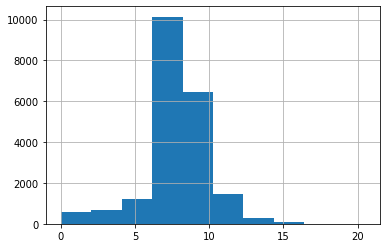

In [49]:
daily['Entered Hours'].hist()

In [50]:
daily.sort_values('Entered Hours', ascending=False).head(20)

,Employee ID,Hours Date,Entered Hours,Work Schedule,Effective Date,FTE Hours
13571,100043.0,2020-05-28,20.50,0.75,2020-05-28,6.0
13570,100043.0,2020-05-27,19.50,0.75,2020-05-27,6.0
10523,100030.0,2019-09-30,19.50,1.00,2019-09-30,8.0
6226,100017.0,2019-08-14,19.17,1.00,2019-08-14,8.0
13569,100043.0,2020-05-26,19.00,0.75,2020-05-26,6.0
5316,100015.0,2019-09-11,18.82,1.00,2019-09-11,8.0
5307,100015.0,2019-09-02,18.50,1.00,2019-09-02,8.0
13572,100043.0,2020-05-29,18.00,0.75,2020-05-29,6.0
10540,100030.0,2019-10-22,18.00,1.00,2019-10-22,8.0
6161,100017.0,2019-05-19,18.00,1.00,2019-05-19,0.0


In [51]:
daily[daily['Entered Hours'] == daily['Entered Hours'].max()]

,Employee ID,Hours Date,Entered Hours,Work Schedule,Effective Date,FTE Hours
13571,100043.0,2020-05-28,20.5,0.75,2020-05-28,6.0


In [52]:
emp_df[emp_df['Employee ID']==100043]

,Employee ID,Last Name,First Name,Hire date,Termination date,Work Schedule,Effective Date,User Name
49,100043,Exline,Kelly,2019-04-15,2021-01-07,75,2019-04-15,"Exline, Kelly"


In [53]:
daily[daily['Entered Hours'] >= 16]\
    .groupby('Employee ID')['Entered Hours']\
    .count()\
    .sort_values(ascending=False)

Employee ID
100082.0    9
100001.0    5
100015.0    4
100030.0    4
100043.0    4
100017.0    2
100004.0    1
100008.0    1
100016.0    1
100025.0    1
100026.0    1
100067.0    1
100101.0    1
Name: Entered Hours, dtype: int64

In [54]:
hours_report[hours_report['Entered Hours'] >= 16]
# Note this will only show when single entries were
# greater than 16 and will not reflect adjustments
# to daily dataframe.

,Employee ID,Work Schedule Description,Org Name,Task ID,Task Name,User Defined Code 3,Hours Date,Entered Hours,Approved Hours,Comments,Entry Month,Entry Year,User Name,Classification,Project
2308,100001.0,Standard,Company Health,None,R&D (USAID),IRD,2019-09-11,17.20,0,None,Sep,2019,"Alexandrovich, Andrew",R&D,None
22031,100015.0,Standard,International,None,R&D (USAID),IRD,2019-09-09,16.17,0,None,Sep,2019,"Lauck, Elizabeth",R&D,None
22035,100015.0,Standard,International,None,R&D (USAID),IRD,2019-09-11,17.15,0,None,Sep,2019,"Lauck, Elizabeth",R&D,None
24654,100016.0,Standard,International,None,R&D (USAID),IRD,2019-09-11,17.80,0,None,Sep,2019,"Nease, Patrick",R&D,None
25786,100017.0,Standard,International,None,"SWS Task 1: Learning Team, P&L, Annual Meeting",SRV,2019-05-19,18.00,0,None,May,2019,"Peabody, Shawn",Billable,None
25971,100017.0,Standard,International,None,MI2_6.1.MAD.TasksA&E,SRV,2019-08-14,19.17,0,None,Aug,2019,"Peabody, Shawn",Billable,None
36430,100083.0,Standard,Global Adaptive Managemen,1009.004.100.01,PPL/LER 1,SRV,2020-12-01,16.00,0,direct support to PPL,Dec,2020,"Ballard, Elisa",Billable,PCM
36432,100083.0,Standard,Global Adaptive Managemen,1009.004.100.01,PPL/LER 1,SRV,2020-12-04,16.00,0,direct support to PPL,Dec,2020,"Ballard, Elisa",Billable,PCM
36433,100083.0,Standard,Global Adaptive Managemen,1009.004.100.01,PPL/LER 1,SRV,2020-12-07,16.00,0,direct support to PPL,Dec,2020,"Ballard, Elisa",Billable,PCM
36434,100083.0,Standard,Global Adaptive Managemen,1009.004.100.01,PPL/LER 1,SRV,2020-12-08,16.00,0,direct support to PPL,Dec,2020,"Ballard, Elisa",Billable,PCM


In [55]:
# Top five and bottom five by FTE
overall_effort = daily.groupby('Employee ID')[['Entered Hours', 'FTE Hours']].sum()
overall_effort['FTE'] = overall_effort['Entered Hours']/overall_effort['FTE Hours']
overall_effort.sort_values('FTE', ascending=False)

,Entered Hours,FTE Hours,FTE
Employee ID,,,
100018.0,3203.88,1873.2,1.710378
100095.0,1108.50,792.0,1.399621
100001.0,4527.97,3776.0,1.199145
100030.0,4501.50,3792.0,1.187104
100015.0,4491.17,3800.0,1.181887
...,...,...,...
100092.0,911.50,912.0,0.999452
100073.0,1836.50,1880.0,0.976862
100005.0,2366.65,2438.4,0.970575


In [56]:
overall_effort[overall_effort['FTE'] < 1].sort_values('FTE', ascending=False)

,Entered Hours,FTE Hours,FTE
Employee ID,,,
100092.0,911.50,912.0,0.999452
100073.0,1836.50,1880.0,0.976862
100005.0,2366.65,2438.4,0.970575
100043.0,2311.90,2520.0,0.917421
100105.0,118.50,152.0,0.779605


<AxesSubplot:>

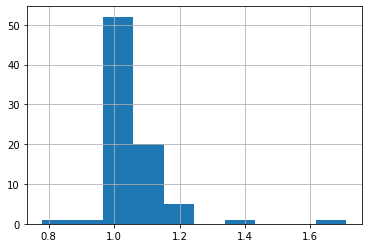

In [57]:
overall_effort['FTE'].hist()

In [58]:
overall_effort[overall_effort['FTE'] > 1.2]

,Entered Hours,FTE Hours,FTE
Employee ID,,,
100018.0,3203.88,1873.2,1.710378
100095.0,1108.50,792.0,1.399621


### Data Quality Concerns
* See high single day billing for i.e., Kelly Exline and Richard Spenser
* Tess Work Status may not reflect her full time work
* Not fully reflecting some part time status (Laurel Wolfe in early 2019)
* Not fully reflecting time off (Caroline Cook for maternity)

<a id='data_analysis'></a>

## Exploratory Data Analysis
* Overall effort
    * Total
    * Per weekday
    * Over time
    * COVID vs. pre-COVID
* Long days
* Working Weekends
* Part timers
* Comparison across portfolios
* Comparison across teams
* Volatility
    * COVID vs. pre-COVID

### Overall effort
* How much do employees work on average?

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

In [61]:
daily.head()

,Employee ID,Hours Date,Entered Hours,Work Schedule,Effective Date,FTE Hours
0,100001.0,2019-04-01,5.30,1.0,2019-04-01,8.0
1,100001.0,2019-04-02,9.05,1.0,2019-04-02,8.0
2,100001.0,2019-04-03,11.26,1.0,2019-04-03,8.0
3,100001.0,2019-04-04,7.47,1.0,2019-04-04,8.0
4,100001.0,2019-04-05,7.20,1.0,2019-04-05,8.0


In [62]:
daily['FTE Pct'] = daily['Entered Hours']/daily['FTE Hours']
daily.head()

,Employee ID,Hours Date,Entered Hours,Work Schedule,Effective Date,FTE Hours,FTE Pct
0,100001.0,2019-04-01,5.30,1.0,2019-04-01,8.0,0.66250
1,100001.0,2019-04-02,9.05,1.0,2019-04-02,8.0,1.13125
2,100001.0,2019-04-03,11.26,1.0,2019-04-03,8.0,1.40750
3,100001.0,2019-04-04,7.47,1.0,2019-04-04,8.0,0.93375
4,100001.0,2019-04-05,7.20,1.0,2019-04-05,8.0,0.90000


In [63]:
# What is our average % FTE? 
avg_fte = daily['Entered Hours'].sum() / daily['FTE Hours'].sum()
print(f'{avg_fte:.1%}, {avg_fte * 40:.1f} hrs per week (for a full time employee)')

107.2%, 42.9 hrs per week (for a full time employee)


In [64]:
# What if we exclude partners?
partners = [100029, 100030, 100015, 100001]
filt = ~daily['Employee ID'].isin(partners)
staff_fte = daily.loc[filt, 'Entered Hours'].sum() / daily.loc[filt, 'FTE Hours'].sum()
print(f'{staff_fte:.1%}, {staff_fte * 40:.1f} hrs per week (for a full time employee)')

106.1%, 42.4 hrs per week (for a full time employee)


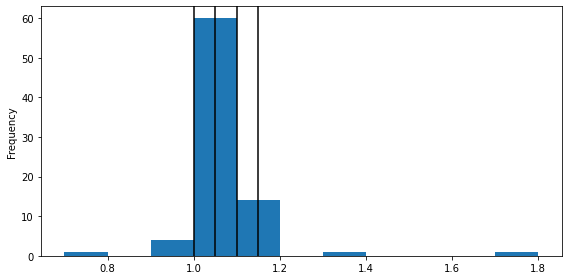

In [129]:
ax = overall_effort['FTE'].plot(kind='hist', figsize=(8,4), bins=[.7,.8,.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8])
ax.axvline(1.0, color='black')
ax.axvline(1.05, color='black')
ax.axvline(1.1, color='black')
ax.axvline(1.15, color='black')
plt.tight_layout()
plt.show()

In [123]:
overall_effort[overall_effort['FTE']>1.15]

,Entered Hours,FTE Hours,FTE
Employee ID,,,
100001.0,4527.97,3776.0,1.199145
100015.0,4491.17,3800.0,1.181887
100018.0,3203.88,1873.2,1.710378
100030.0,4501.50,3792.0,1.187104
100095.0,1108.50,792.0,1.399621
100096.0,586.50,504.0,1.163690
100098.0,774.50,672.0,1.152530


In [133]:
emp_over_115 = overall_effort[overall_effort['FTE']>1.15].index.unique()
filt = emp_df['Employee ID'].isin(emp_over_115)
emp_df.loc[filt]

,Employee ID,Last Name,First Name,Hire date,Termination date,Work Schedule,Effective Date,User Name
0,100001,Alexandrovich,Andrew,2010-04-05,NaT,STD,2010-04-05,"Alexandrovich, Andrew"
21,100015,Lauck,Elizabeth,2013-05-03,NaT,STD,2013-05-03,"Lauck, Elizabeth"
22,100015,Lauck,Elizabeth,2013-05-03,NaT,STD,2020-12-01,"Lauck, Elizabeth"
25,100018,Present,Teresa,2014-02-10,2020-09-30,75,2014-02-10,"Present, Teresa"
41,100030,Praul,Chad,2013-05-03,NaT,STD,2013-05-03,"Praul, Chad"
99,100095,Owusu,Philip,2020-09-15,NaT,STD,2020-09-15,"Owusu, Philip"
100,100096,Walter,Karen,2020-09-22,2021-12-17,STD,2020-09-22,"Walter, Karen"
102,100098,Richards,Anjali,2020-10-06,NaT,STD,2020-10-06,"Richards, Anjali"
103,100098,Richards,Anjali,2020-10-06,NaT,STD,2020-10-16,"Richards, Anjali"


In [66]:
# What days do we work?
daily['Week'] = daily['Hours Date'].dt.isocalendar().week
daily['Month'] = daily['Hours Date'].dt.strftime('%b')
daily['Year'] = daily['Hours Date'].dt.year
daily['Weekday'] = daily['Hours Date'].dt.day_name()

In [67]:
weekday = daily.groupby(['Weekday'])[['Entered Hours', 'FTE Hours']].sum()
weekday['FTE Pct'] = weekday['Entered Hours']/weekday['FTE Hours']
weekday.sort_values('FTE Pct')

,Entered Hours,FTE Hours,FTE Pct
Weekday,,,
Friday,30414.75,31001.6,0.981070
Monday,32984.12,31046.8,1.062400
Thursday,33660.74,31380.0,1.072681
Wednesday,34029.18,31437.2,1.082449
Tuesday,34362.08,31408.8,1.094027
Saturday,890.33,28.8,30.914236
Sunday,1220.72,24.0,50.863333


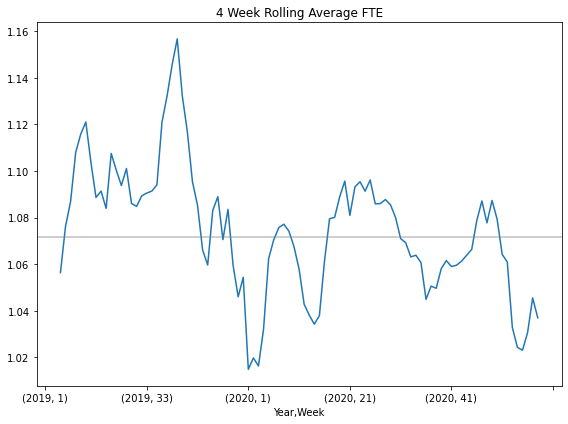

In [68]:
# how has weekly effort changed over time?
dff = daily.groupby(['Year', 'Week'])[['Entered Hours', 'FTE Hours']].sum()
dff['FTE Pct'] = dff['Entered Hours'] / dff['FTE Hours']
ax = dff['FTE Pct'].rolling(4).mean().plot(title='4 Week Rolling Average FTE',
                                           figsize=(8,6))  # 4 week rolling average
ax.axhline(avg_fte, color='grey', alpha=.5)
plt.tight_layout()
plt.show()

In [69]:
dff[dff['FTE Pct'] == dff['FTE Pct'].max()]

,,Entered Hours,FTE Hours,FTE Pct
Year,Week,,,
2019,36,1518.72,1254.0,1.2111


In [70]:
from datetime import datetime
datetime.fromisocalendar(2019, 36, 1).month

9

In [71]:
# Did we work more or less in SY 2019 than SY 2020?
filt = daily['Hours Date'] < pd.to_datetime('2020-04-01')
SY2019_hours = daily.loc[filt, ['Entered Hours', 'FTE Hours']].sum()
SY2020_hours = daily.loc[~filt, ['Entered Hours', 'FTE Hours']].sum()
SY2019_fte = SY2019_hours['Entered Hours'] / SY2019_hours['FTE Hours']
SY2020_fte = SY2020_hours['Entered Hours'] / SY2020_hours['FTE Hours']
print(f"SY2019: {SY2019_fte:.1%}, SY2020: {SY2020_fte:.1%}")

SY2019: 108.0%, SY2020: 106.6%


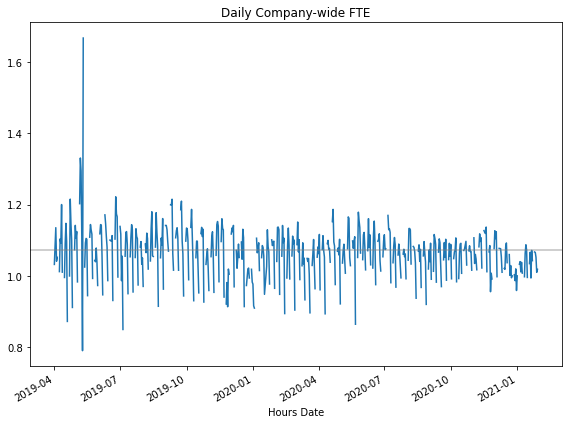

In [72]:
# What is the daily variability in our FTE pct?
df = daily.groupby('Hours Date')['FTE Pct'].mean()
ax = df.plot(title='Daily Company-wide FTE', figsize=(8,6))
ax.axhline(avg_fte, color='grey', alpha=.5)
plt.tight_layout()
plt.show()

In [73]:
# How do individual FTE pcts change over time?
weekly = daily.groupby(['Year', 'Week', 'Employee ID'])[['Entered Hours', 'FTE Hours']].sum().reset_index()
weekly['FTE Pct'] = weekly['Entered Hours'] / weekly['FTE Hours']
weekly

,Year,Week,Employee ID,Entered Hours,FTE Hours,FTE Pct
0,2019,1,100001.0,12.84,16.0,0.802500
1,2019,1,100003.0,16.00,16.0,1.000000
2,2019,1,100004.0,17.00,16.0,1.062500
3,2019,1,100005.0,12.80,12.8,1.000000
4,2019,1,100007.0,11.75,12.0,0.979167
...,...,...,...,...,...,...
4203,2021,53,100100.0,8.00,8.0,1.000000
4204,2021,53,100101.0,8.00,8.0,1.000000
4205,2021,53,100102.0,8.00,8.0,1.000000
4206,2021,53,100103.0,8.00,8.0,1.000000


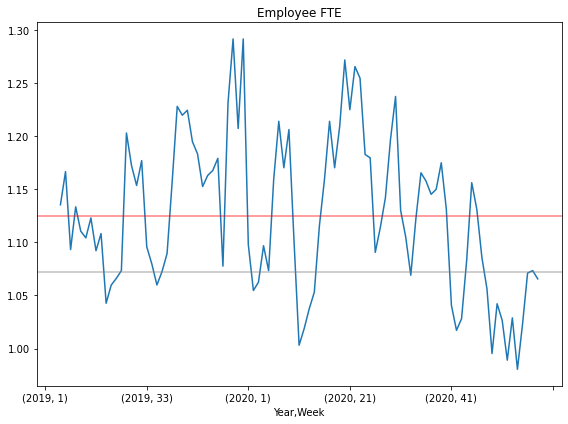

In [74]:
# Example individual chart
weekly_pivot = weekly.pivot(index=['Year', 'Week'], 
                  columns='Employee ID', 
                  values='FTE Pct')
ax = weekly_pivot.loc[:, 100029].rolling(4).mean().plot(title='Employee FTE', figsize=(8,6))
ax.axhline(avg_fte, color='grey', alpha=.5)
ax.axhline(weekly_pivot.loc[:, 100029].mean(), color='red', alpha=0.5)
plt.tight_layout()
plt.show()

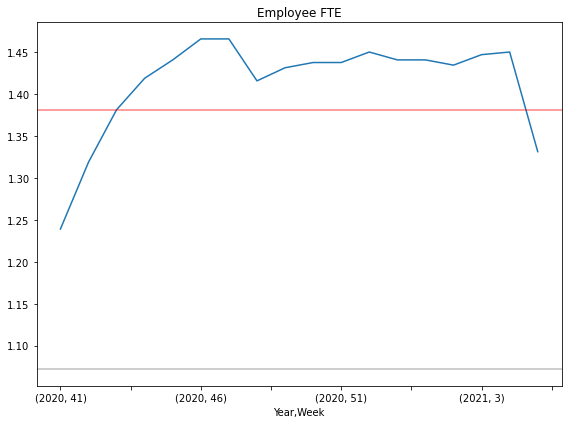

In [75]:
# Example individual chart
ax = weekly_pivot.loc[:, 100095].rolling(4).mean().plot(title='Employee FTE', figsize=(8,6))
ax.axhline(avg_fte, color='grey', alpha=.5)
ax.axhline(weekly_pivot.loc[:, 100095].mean(), color='red', alpha=0.5)
plt.tight_layout()
plt.show()

In [76]:
# Individual average FTE %
filt = daily['Employee ID'] == 100029 
daily.loc[filt, 'Entered Hours'].sum() / daily.loc[filt, 'FTE Hours'].sum()

1.1279009433962264

In [77]:
weekly_pivot.loc[:, 100029].mean()

1.124922193877551

In [78]:
len(weekly_pivot.columns)

81

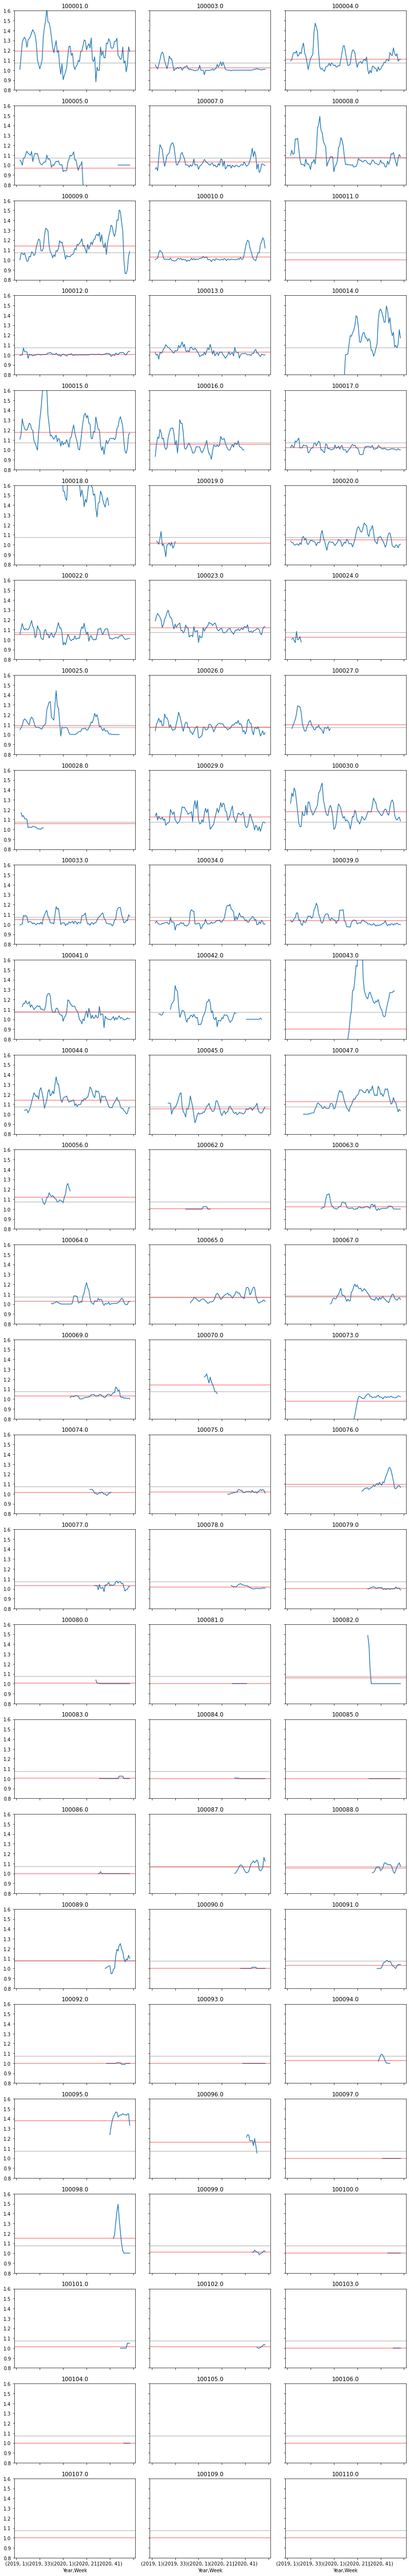

In [110]:
fig, axes = plt.subplots(27, 3, figsize=(12, 75), sharex=True, sharey=True)

for ax, emp in zip(axes.ravel(), weekly_pivot.columns):
    weekly_pivot.loc[:, emp].rolling(4, min_periods=4)\
        .mean()\
        .plot(ax=ax)
    ax.set_ylim(.8, 1.6)
    ax.set_title(emp)

for ax in axes.ravel():
    ax.axhline(avg_fte, color='grey', alpha=.5)
    
for ax, emp in zip(axes.ravel(), weekly_pivot.columns):
    emp_avg = weekly_pivot.loc[:, emp].mean()
    ax.axhline(emp_avg, color='red', alpha=.5)
    
plt.tight_layout()
plt.savefig('employee_fte')
plt.show()

### Breakdown of Hours

In [80]:
# Name of the file, excluding any appended numeric distinguisher for repeats
org_fn = 'Organizations'
# read it in
org_in = get_latest_file(downloads, org_fn)
org_df = pd.read_csv(org_in, sep='\t',
                   encoding='utf_16_le')
org_df

C:/Users/Erik/Downloads/Organizations (2).csv


,Project ID,Project Name,Organization ID,Organization Name,Level Number
0,1001,USAID Measuring Impact II,1.01.01.02,Global Adaptive Managemen,4
1,1001.AFR,BI-AFR,1.01.01.04,Africa,4
2,1001.AFR.001,BI-AFR,1.01.01.04,Africa,4
3,1001.AFR.001.01,16.0.AFR_BuyIn_Mgmt,1.01.01.04,Africa,4
4,1001.AFR.001.02,16.0.AFR_Zambia FS,1.01.01.04,Africa,4
...,...,...,...,...,...
742,LGCY.016,LEGACY FAC,1.01.90.01.01,HR & Ops General,5
743,LGCY.017,LEGACY B&P,1.01.90.01.01,HR & Ops General,5
744,LGCY.018,LEGACY R&D,1.01.90.01.01,HR & Ops General,5
745,UNAL,Unallowable Accounts,1.01.90.01.01,HR & Ops General,5


In [81]:
# confirm Project ID is unique
len(org_df) == len(org_df['Project ID'].unique())

True

In [82]:
# merge hours entries and organizations
org_hours = pd.merge(hours_report, org_df, how='inner', left_on='Task ID', right_on='Project ID')
org_hours

,Employee ID,Work Schedule Description,Org Name,Task ID,Task Name,User Defined Code 3,Hours Date,Entered Hours,Approved Hours,Comments,Entry Month,Entry Year,User Name,Classification,Project,Project ID,Project Name,Organization ID,Organization Name,Level Number
0,100001.0,Standard,Company Health,INDR.001.009.01,Planning and Ops CH,G&A,2020-06-01,10.63,0,NaN,Jun,2020,"Alexandrovich, Andrew",G&A,G&A,INDR.001.009.01,Planning and Ops CH,1.01.90.01,HR and Operations,4
1,100001.0,Standard,Company Health,INDR.001.009.01,Planning and Ops CH,G&A,2020-06-02,7.50,0,NaN,Jun,2020,"Alexandrovich, Andrew",G&A,G&A,INDR.001.009.01,Planning and Ops CH,1.01.90.01,HR and Operations,4
2,100001.0,Standard,Company Health,INDR.001.009.01,Planning and Ops CH,G&A,2020-06-03,5.86,0,NaN,Jun,2020,"Alexandrovich, Andrew",G&A,G&A,INDR.001.009.01,Planning and Ops CH,1.01.90.01,HR and Operations,4
3,100001.0,Standard,Company Health,INDR.001.009.01,Planning and Ops CH,G&A,2020-06-04,5.00,0,NaN,Jun,2020,"Alexandrovich, Andrew",G&A,G&A,INDR.001.009.01,Planning and Ops CH,1.01.90.01,HR and Operations,4
4,100001.0,Standard,Company Health,INDR.001.009.01,Planning and Ops CH,G&A,2020-06-05,5.23,0,NaN,Jun,2020,"Alexandrovich, Andrew",G&A,G&A,INDR.001.009.01,Planning and Ops CH,1.01.90.01,HR and Operations,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35355,100109.0,Standard Kenya,Global Adaptive Managemen,1009.003.200.01,KEA FFP Accountability,SRV,2021-01-27,8.00,0,Supporting USAID/BHA-ECARO with prorammatic an...,Jan,2021,"Srikanth, Sushmita",Billable,PCM,1009.003.200.01,KEA FFP Accountability,1.01.01.02,Global Adaptive Managemen,4
35356,100109.0,Standard Kenya,Global Adaptive Managemen,1009.003.200.01,KEA FFP Accountability,SRV,2021-01-28,8.00,0,NaN,Jan,2021,"Srikanth, Sushmita",Billable,PCM,1009.003.200.01,KEA FFP Accountability,1.01.01.02,Global Adaptive Managemen,4
35357,100109.0,Standard Kenya,Global Adaptive Managemen,1009.003.200.01,KEA FFP Accountability,SRV,2021-01-28,8.00,0,Supporting USAID/BHA-ECARO with prorammatic an...,Jan,2021,"Srikanth, Sushmita",Billable,PCM,1009.003.200.01,KEA FFP Accountability,1.01.01.02,Global Adaptive Managemen,4
35358,100109.0,Standard Kenya,Global Adaptive Managemen,1009.003.200.01,KEA FFP Accountability,SRV,2021-01-29,8.00,0,NaN,Jan,2021,"Srikanth, Sushmita",Billable,PCM,1009.003.200.01,KEA FFP Accountability,1.01.01.02,Global Adaptive Managemen,4


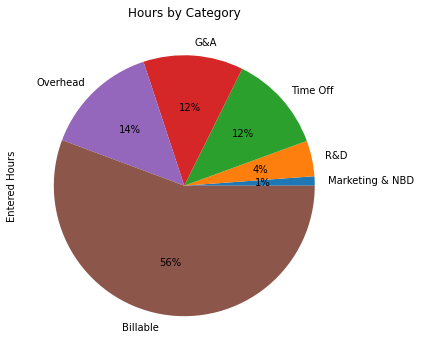

In [126]:
org_hours.groupby('Classification')['Entered Hours']\
    .sum()\
    .sort_values()\
    .plot(kind='pie', figsize=(8,6), title='Hours by Category', autopct='%1.0f%%')
plt.tight_layout
plt.show()

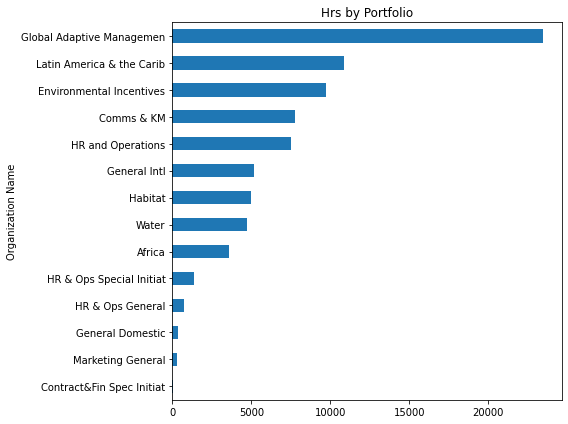

In [84]:
org_hours.groupby('Organization Name')['Entered Hours']\
    .sum()\
    .sort_values()\
    .plot(kind='barh', figsize=(8,6), title='Hrs by Portfolio')
plt.tight_layout()
plt.show()

### Effort by Portfolio

In [85]:
emp_org_df = org_hours.groupby(['Employee ID', 'Organization Name'])\
    ['Entered Hours']\
    .sum()\
    .reset_index()
emp_org_df.head()

,Employee ID,Organization Name,Entered Hours
0,100001.0,Comms & KM,0.25
1,100001.0,Environmental Incentives,101.01
2,100001.0,General Domestic,208.34
3,100001.0,General Intl,132.25
4,100001.0,Global Adaptive Managemen,55.54


In [86]:
org_pivot = emp_org_df.pivot(index='Organization Name', 
                  columns='Employee ID', 
                  values='Entered Hours')
org_pivot

Employee ID,100001.0,100003.0,100004.0,100005.0,100007.0,100008.0,100009.0,100010.0,100012.0,100013.0,...,100100.0,100101.0,100102.0,100103.0,100104.0,100105.0,100106.0,100107.0,100109.0,100110.0
Organization Name,,,,,,,,,,,,,,,,,,,,,
Africa,NaN,NaN,1.50,NaN,42.85,868.20,71.20,8.70,NaN,7.00,...,NaN,NaN,48.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Comms & KM,0.25,499.50,116.75,NaN,NaN,NaN,1174.50,1054.55,1181.05,NaN,...,NaN,NaN,14.75,NaN,NaN,72.5,NaN,NaN,NaN,NaN
Contract&Fin Spec Initiat,NaN,6.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Environmental Incentives,101.01,744.00,245.00,527.6,316.65,126.30,97.20,136.25,141.00,253.00,...,80.0,52.0,56.00,48.0,32.0,6.0,NaN,NaN,NaN,NaN
General Domestic,208.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
General Intl,132.25,144.00,858.20,NaN,4.75,2.35,6.25,0.83,92.40,67.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Global Adaptive Managemen,55.54,1.00,224.00,10.0,700.10,94.92,18.90,56.45,NaN,1037.75,...,448.0,NaN,283.00,312.0,287.0,NaN,72.0,72.0,128.0,NaN
HR & Ops General,0.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0
HR & Ops Special Initiat,NaN,0.75,17.25,NaN,NaN,NaN,3.35,4.33,0.50,1.00,...,NaN,NaN,5.50,NaN,1.0,NaN,NaN,NaN,NaN,NaN


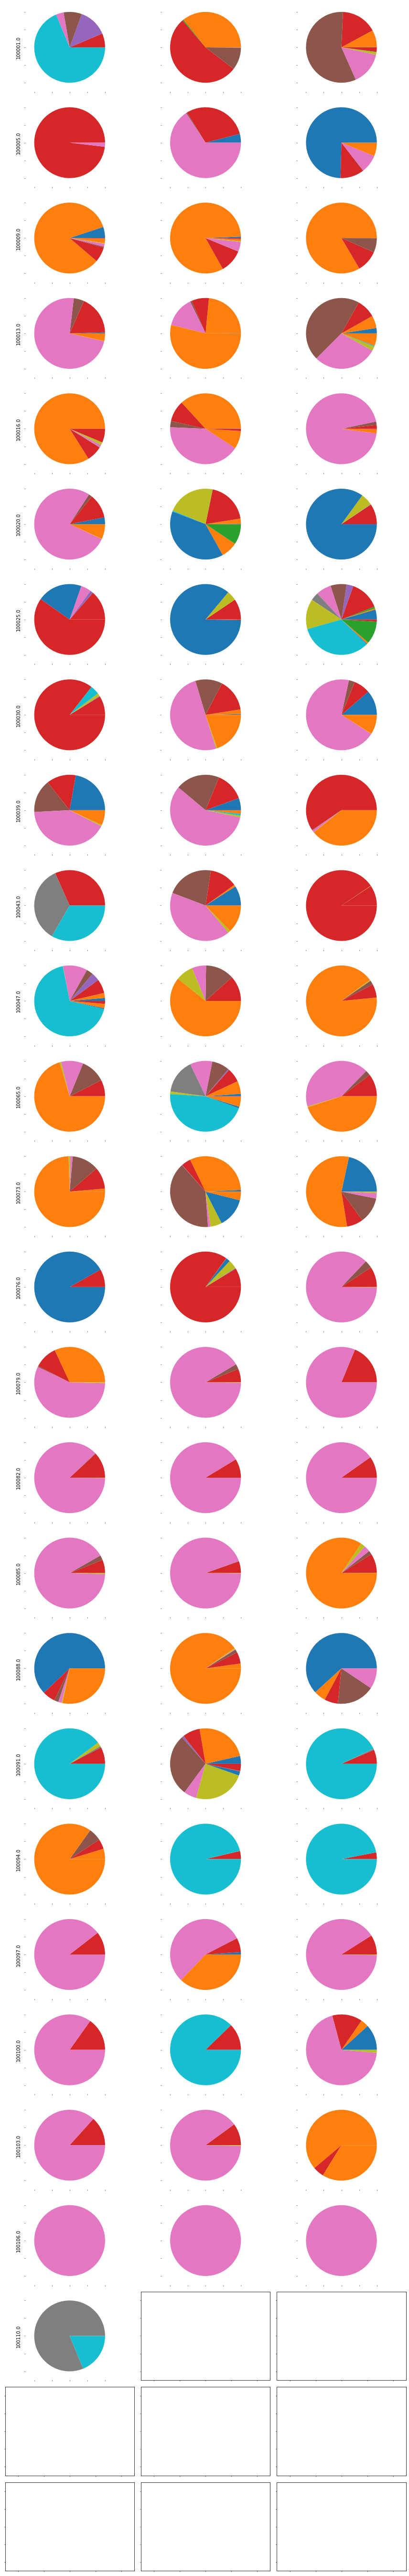

In [87]:
fig, axes = plt.subplots(27, 3, figsize=(12, 75), sharex=True, sharey=True)

for ax, emp in zip(axes.ravel(), org_pivot.columns):
    org_pivot.loc[:, emp].plot(kind='pie', ax=ax, labels=None)
plt.tight_layout()
plt.show()

Most people spend >75% of their time in one portfolio, while some spend at least 50% in one and dabble in others. A very few are split less than a third to any one portfolio.

For the purposes of this analysis, we'll consider anyone who spends more than 33% of their time in a portfolio to be 'in' that portfolio.

In [88]:
org_pivot_pct = pd.DataFrame(index=org_pivot.index)
for column in org_pivot.columns:
    org_pivot_pct[column] = org_pivot[column] / org_pivot.sum()[column]

In [89]:
org_pivot_pct

,100001.0,100003.0,100004.0,100005.0,100007.0,100008.0,100009.0,100010.0,100012.0,100013.0,...,100100.0,100101.0,100102.0,100103.0,100104.0,100105.0,100106.0,100107.0,100109.0,100110.0
Organization Name,,,,,,,,,,,,,,,,,,,,,
Africa,NaN,NaN,0.001003,NaN,0.040259,0.745960,0.050716,0.006801,NaN,0.004944,...,NaN,NaN,0.117864,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Comms & KM,0.000157,0.357872,0.078057,NaN,NaN,NaN,0.836598,0.824350,0.834694,NaN,...,NaN,NaN,0.036219,NaN,NaN,0.611814,NaN,NaN,NaN,NaN
Contract&Fin Spec Initiat,NaN,0.004657,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Environmental Incentives,0.063442,0.533047,0.163803,0.981399,0.297506,0.108517,0.069236,0.106508,0.099650,0.178704,...,0.151515,0.122642,0.137508,0.133333,0.100000,0.050633,NaN,NaN,NaN,NaN
General Domestic,0.130854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
General Intl,0.083063,0.103170,0.573778,NaN,0.004463,0.002019,0.004452,0.000649,0.065303,0.047678,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Global Adaptive Managemen,0.034883,0.000716,0.149763,0.018601,0.657772,0.081556,0.013462,0.044127,NaN,0.733004,...,0.848485,NaN,0.694905,0.866667,0.896875,NaN,1.0,1.0,1.0,NaN
HR & Ops General,0.000157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8125
HR & Ops Special Initiat,NaN,0.000537,0.011533,NaN,NaN,NaN,0.002386,0.003385,0.000353,0.000706,...,NaN,NaN,0.013505,NaN,0.003125,NaN,NaN,NaN,NaN,NaN


In [90]:
emp_org_dict = {}
for column in org_pivot_pct:
    filt = org_pivot_pct[column] > 0.33
    emp_org_dict[column] = org_pivot_pct.loc[filt, column].index.to_list()
emp_org_dict

{100001.0: ['HR and Operations'],
 100003.0: ['Comms & KM', 'Environmental Incentives'],
 100004.0: ['General Intl'],
 100005.0: ['Environmental Incentives'],
 100007.0: ['Global Adaptive Managemen'],
 100008.0: ['Africa'],
 100009.0: ['Comms & KM'],
 100010.0: ['Comms & KM'],
 100012.0: ['Comms & KM'],
 100013.0: ['Global Adaptive Managemen'],
 100014.0: ['Latin America & the Carib'],
 100015.0: ['General Intl'],
 100016.0: ['Comms & KM'],
 100017.0: ['Comms & KM', 'Global Adaptive Managemen'],
 100018.0: ['Global Adaptive Managemen'],
 100020.0: ['Global Adaptive Managemen'],
 100022.0: ['Habitat'],
 100023.0: ['Habitat'],
 100025.0: ['Water'],
 100026.0: ['Habitat'],
 100029.0: ['HR and Operations'],
 100030.0: ['Water'],
 100033.0: ['Global Adaptive Managemen'],
 100034.0: ['Global Adaptive Managemen'],
 100039.0: ['Global Adaptive Managemen'],
 100041.0: ['Global Adaptive Managemen'],
 100042.0: ['Environmental Incentives', 'Latin America & the Carib'],
 100043.0: ['HR & Ops Gener

In [91]:
emp_df[emp_df['Employee ID'] == '100092']

,Employee ID,Last Name,First Name,Hire date,Termination date,Work Schedule,Effective Date,User Name


In [92]:
portfolio_emp_dict = {}
 
for k, value in emp_org_dict.items():
    for v in value:
        portfolio_emp_dict.setdefault(v,[]).append(k)

emp_df[emp_df['Employee ID'].isin(portfolio_emp_dict['HR and Operations'])]

portfolio_emp_dict

{'HR and Operations': [100001.0,
  100029.0,
  100043.0,
  100047.0,
  100067.0,
  100091.0,
  100093.0,
  100095.0,
  100096.0,
  100101.0],
 'Comms & KM': [100003.0,
  100009.0,
  100010.0,
  100012.0,
  100016.0,
  100017.0,
  100075.0,
  100105.0],
 'Environmental Incentives': [100003.0, 100005.0, 100042.0],
 'General Intl': [100004.0, 100015.0, 100074.0],
 'Global Adaptive Managemen': [100007.0,
  100013.0,
  100017.0,
  100018.0,
  100020.0,
  100033.0,
  100034.0,
  100039.0,
  100041.0,
  100044.0,
  100069.0,
  100078.0,
  100079.0,
  100080.0,
  100081.0,
  100082.0,
  100083.0,
  100084.0,
  100085.0,
  100086.0,
  100097.0,
  100098.0,
  100099.0,
  100100.0,
  100102.0,
  100103.0,
  100104.0,
  100106.0,
  100107.0,
  100109.0],
 'Africa': [100008.0, 100088.0, 100090.0],
 'Latin America & the Carib': [100014.0,
  100042.0,
  100063.0,
  100064.0,
  100065.0,
  100069.0,
  100073.0,
  100087.0,
  100089.0,
  100094.0,
  100098.0,
  100105.0],
 'Habitat': [100022.0, 100023.

In [93]:
portfolio_pivot = pd.DataFrame(index = weekly_pivot.index)
for portfolio in portfolio_emp_dict.keys():
    filt = daily['Employee ID'].isin(portfolio_emp_dict[portfolio])
    df1 = daily.loc[filt].groupby(['Year', 'Week']).sum()
    portfolio_pivot[portfolio] = df1['Entered Hours'] / df1['FTE Hours']
portfolio_pivot

HR and Operations  Comms & KM  Environmental Incentives  \
Year Week                                                            
2019 1              0.903286    0.943427                  1.022321   
     14             1.162875    1.035560                  1.107639   
     15             1.055500    1.024440                  1.036806   
     16             0.982273    1.006250                  1.016572   
     17             1.032545    1.072888                  0.965179   
...                      ...         ...                       ...   
2021 1              1.102656    1.005939                  1.017857   
     2              1.099594    1.026318                  0.984375   
     3              1.161125    1.027868                  1.013889   
     4              1.119250    0.966980                  1.000000   
     53             1.000000    1.000000                  1.000000   

           General Intl  Global Adaptive Managemen    Africa  \
Year Week                                                      
2019 1         1.046875                   1.066444  1.000000   
     14        0.901875                   1.107653  1.132500   
     15        1.241750                   1.067784  1.348437   
     16        1.200000                   1.067725  0.914062   
     17        1.180500                   1.075112  1.203125   
...                 ...                        ...       ...   
2021 1         0.970750                   1.008313  1.072768   
     2         1.189875                   1.005384  1.051786   
     3         1.120000                   1.003442  1.080804   
     4         1.245125                   1.020162  1.070446   
     53        1.000000                   1.000000  1.000000   

           Latin America & the Carib   Habitat     Water  HR & Ops General  
Year Week                                                                   
2019 1                      1.030312  0.873542  1.020833          0.166667  
     14                     0.156250  1.113482  1.253125               NaN  
     15                     0.375000  1.204375  1.087500               NaN  
     16                     0.879464  1.203583  1.284375          0.491667  
     17                     0.879464  1.099417  1.246875          0.500000  
...                              ...       ...       ...               ...  
2021 1                      1.063542  0.999500  1.068333               NaN  
     2                      1.032407  1.085062  1.069583               NaN  
     3                      1.006000  1.134062  1.059167               NaN  
     4                      1.064125  1.006000  1.072500          1.000000  
     53                     1.000000  1.000000  1.041667          1.000000  

[98 rows x 10 columns]

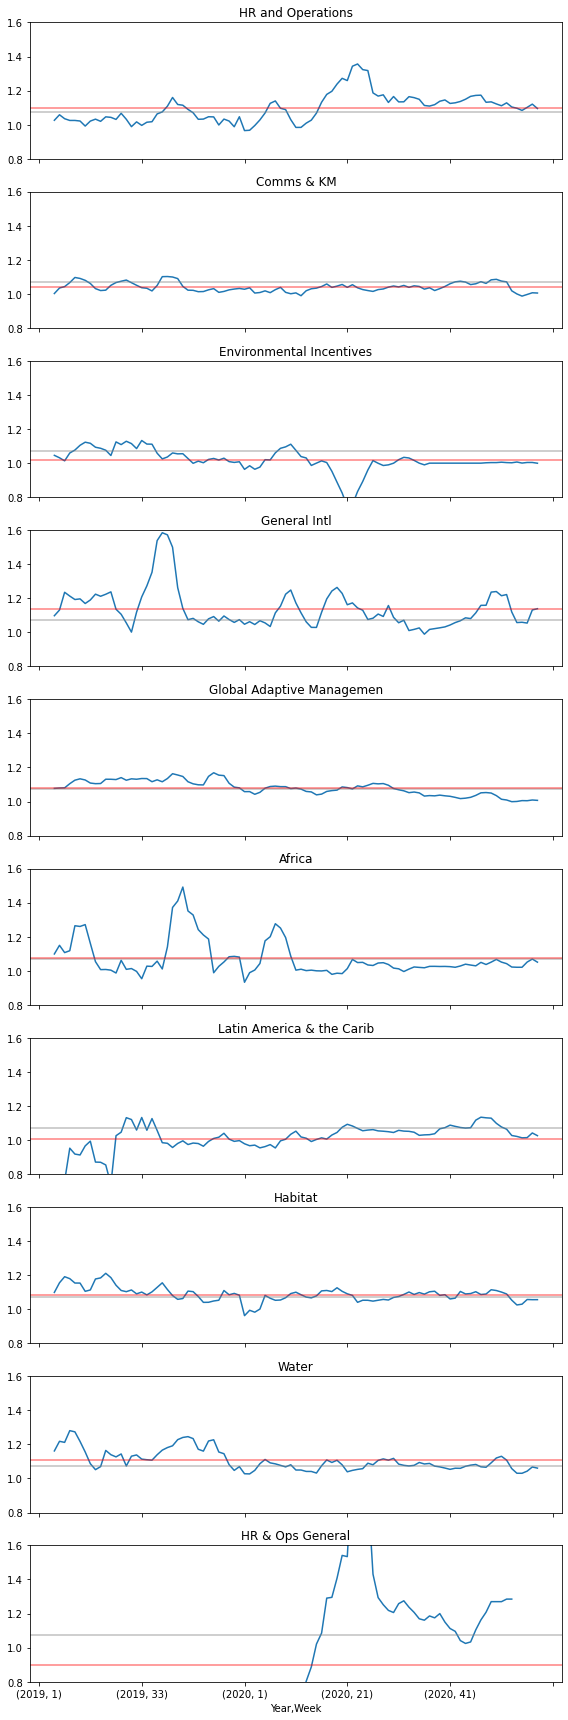

In [94]:
fig, axes = plt.subplots(10, 1, figsize=(8, 24), sharex=True, sharey=True)

for ax, portfolio in zip(axes, portfolio_pivot.columns):
    portfolio_pivot.loc[:, portfolio].rolling(4, min_periods=4)\
        .mean()\
        .plot(ax=ax)
    ax.set_ylim(.8, 1.6)
    ax.set_title(portfolio)

for ax in axes.ravel():
    ax.axhline(avg_fte, color='grey', alpha=.5)
    
for ax, portfolio in zip(axes.ravel(), portfolio_pivot.columns):
    port_avg = portfolio_pivot.loc[:, portfolio].mean()
    ax.axhline(port_avg, color='red', alpha=.5)
    
plt.tight_layout()
plt.show()

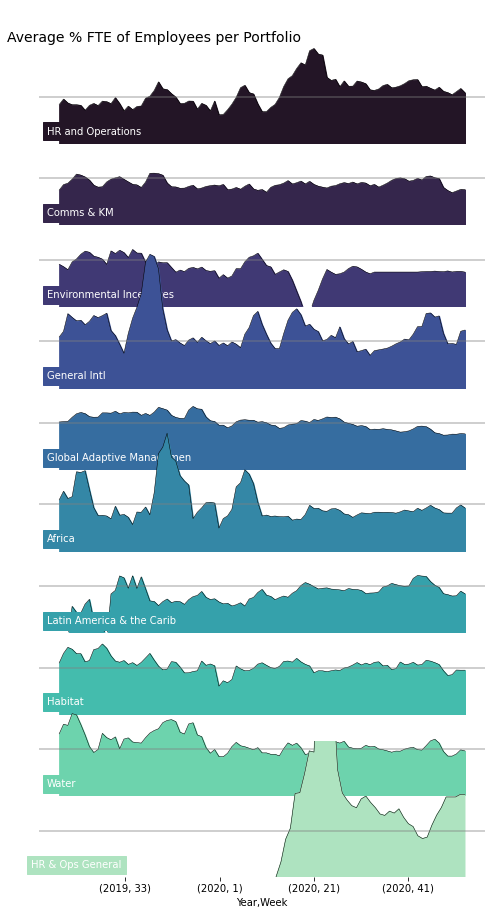

In [95]:
import matplotlib.gridspec as grid_spec
gs = (grid_spec.GridSpec(10, 1))
fig = plt.figure(figsize=(8, 16))

palette = sns.color_palette('mako', 10)

i = 0

#creating empty list
ax_objs = []

for port in portfolio_pivot.columns:
    # creating new axes object and appending to ax_objs
    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))

    # plotting the distribution
    plot = portfolio_pivot.loc[:, port].rolling(4, min_periods=4)\
        .mean()\
        .plot(ax=ax_objs[-1], color='black', lw=0.5)
    
    plot.axhline(avg_fte, color='grey', alpha=0.5)

    # grabbing x and y data from the plot
    x = plot.get_children()[0]._x
    y = plot.get_children()[0]._y

    # filling the space beneath the distribution
    ax_objs[-1].fill_between(x,y,color=palette[i])

    # setting uniform y lims
    ax_objs[-1].set_ylim(.8, 1.6)
    
    # make background transparent
    rect = ax_objs[-1].patch
    rect.set_alpha(0)

    # remove borders, axis ticks, and labels
    ax_objs[-1].get_yaxis().set_visible(False)

    if i == len(portfolio_pivot.columns)-1:
        pass
    else:
        ax_objs[-1].get_xaxis().set_visible(False)

    spines = ["top","right","left","bottom"]
    for s in spines:
        ax_objs[-1].spines[s].set_visible(False)

    ax_objs[-1].text(.07, .85, port, color='white', 
                     backgroundcolor=palette[i])

    i += 1

gs.update(hspace= -.4)

fig.text(0.07,0.85,"Average % FTE of Employees per Portfolio",fontsize=14)

# plt.tight_layout()
plt.show()

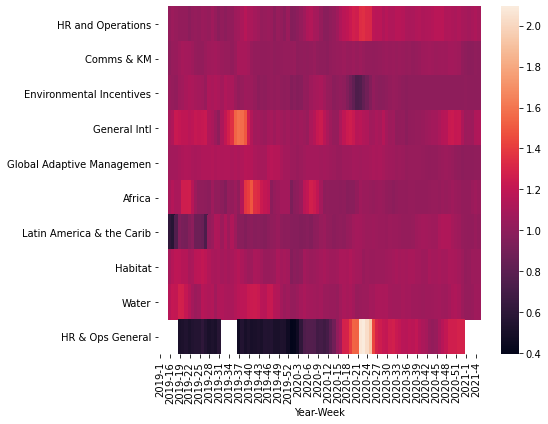

In [96]:
fig, ax = plt.subplots(figsize=(8, 6)) 
sns.heatmap((portfolio_pivot.rolling(4).mean().transpose()))
plt.tight_layout()
plt.show()

### Long Days (> 13 hours)

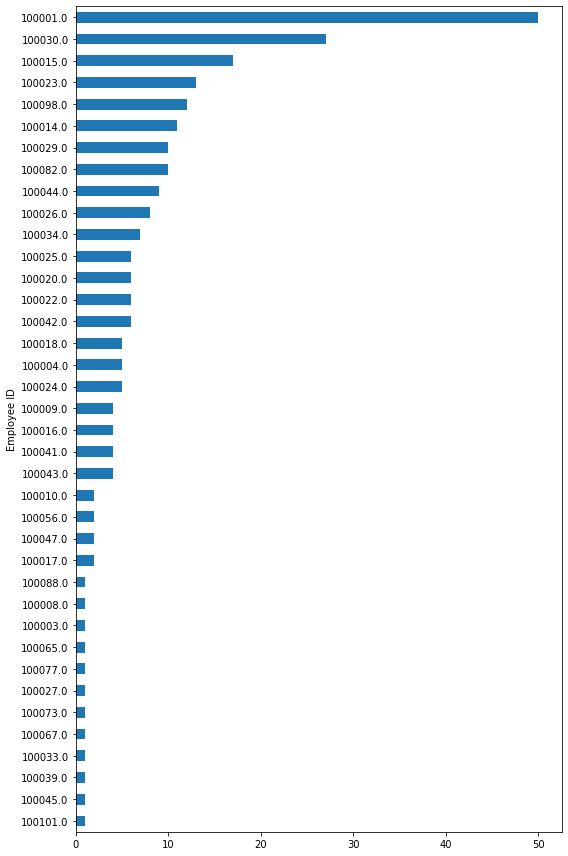

In [97]:
# Long days (> 13 hours)
fig, ax = plt.subplots(figsize=(8,12))
daily[daily['Entered Hours'] >= 13]\
    .groupby('Employee ID')['Entered Hours']\
    .count()\
    .sort_values(ascending=True)\
    .plot(kind='barh')
plt.tight_layout()
plt.show()

## Weekends

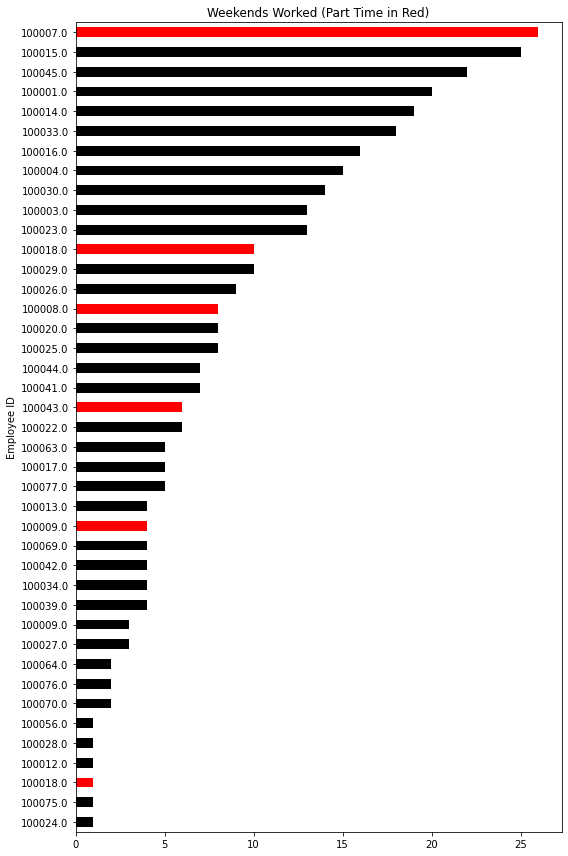

In [144]:
# How many people worked more than two hours on a weekend and how often?
color_dict = {
    1: 'black',
    .8: 'red',
    .75: 'red',
    .6: 'red',
    .5: 'red',
    .45: 'red'
}
fig, ax = plt.subplots(figsize=(8,12))
filt = (~np.is_busday(daily['Hours Date'].values.astype('datetime64[D]'))) & (daily['Entered Hours']>2)

dff = daily.loc[filt]\
    .groupby(['Employee ID', 'Work Schedule'])['Hours Date']\
    .count()\
    .sort_values(ascending=True)\
    .reset_index()\
    .set_index('Employee ID')
dff['Hours Date'].plot(kind='barh',
                       title = 'Weekends Worked (Part Time in Red)',
                       color=[color_dict[x] for x in dff['Work Schedule']])
plt.tight_layout()
plt.show()

### Relative to planned (Domestic only)

In [99]:
scoreboard = pd.read_csv('../data/scoreboard.csv')
scoreboard.head()

,User Name,Entry Year,Entry Month,Project,Hours
0,"Abragan, Maria Celes",2020,Jan,G&A,6.0
1,"Abragan, Maria Celes",2020,Jan,Time Off,16.0
2,"Ajroud, Brittany",2020,Jan,Time Off,16.0
3,"Alexandrovich, Andrew",2020,Jan,G&A,64.5
4,"Alexandrovich, Andrew",2020,Jan,Time Off,16.0


In [100]:
portfolio_emp_dict['Habitat']

[100022.0, 100023.0, 100026.0, 100076.0]

In [101]:
scoreboard['Employee ID'] = scoreboard['User Name'].map(emp_id_dict)
filt = scoreboard['Employee ID'].isin(portfolio_emp_dict['Habitat']+portfolio_emp_dict['Water'])
scoreboard = scoreboard.loc[filt]
scoreboard['Project'].unique()

array(['Mule Deer Habitat Xchange', 'NV CCS', 'OC WQIP TO5 PMs',
       'Overhead', 'SDCo R&I TO2 DEMOS', 'Time Off', 'CV Resilience',
       'DWR CS21 Updates TO47', 'EDF Team Habitat Support', 'Windward',
       'SDCo Pay for Performance', 'OC Aliso TO6', 'Water - Other',
       'DWR HPM TO48', 'Natural Capital of E Afr',
       'Sustainable WASH Systems', 'LACo SW Finance Portfolio', 'SEEK',
       'USAID LAC ESSC', 'USAID Measuring Impact II', 'WSAFCA',
       'SDCo Program Design', 'Pollinator Scorecard II', 'G&A',
       'Walton-SLED', 'East Kaweah RCIS', 'EDF CVRI Workshop Webport',
       'SDCo Runoff Percent Rdct'], dtype=object)

In [102]:
hours_report.head()

,Employee ID,Work Schedule Description,Org Name,Task ID,Task Name,User Defined Code 3,Hours Date,Entered Hours,Approved Hours,Comments,Entry Month,Entry Year,User Name,Classification,Project
0,100041.0,Standard,Company Health,None,HR & Recruiting (Int'l),OVH,2019-04-08,7.0,0,None,Apr,2019,"Abragan, Maria Celes",Overhead,None
1,100041.0,Standard,Company Health,None,General (Int'l),G&A,2019-04-09,2.0,0,None,Apr,2019,"Abragan, Maria Celes",G&A,None
2,100041.0,Standard,Company Health,None,HR & Recruiting (Int'l),OVH,2019-04-09,3.0,0,None,Apr,2019,"Abragan, Maria Celes",Overhead,None
3,100041.0,Standard,Company Health,None,Planning and Ops (Int'l),G&A,2019-04-09,3.0,0,None,Apr,2019,"Abragan, Maria Celes",G&A,None
4,100041.0,Standard,Company Health,None,General (Int'l),G&A,2019-04-10,2.0,0,None,Apr,2019,"Abragan, Maria Celes",G&A,None


In [103]:
hours_act = hours_report.groupby(['Employee ID', 'Entry Month', 'Entry Year', 'Project', 'Classification'])['Entered Hours'].sum()
hours_act = pd.DataFrame(hours_act).reset_index().rename({'Entered Hours': 'Hours'}, axis=1)
hours_act.head()

,Employee ID,Entry Month,Entry Year,Project,Classification,Hours
0,100001.0,Apr,2020,G&A,G&A,200.54
1,100001.0,Apr,2020,Overhead,Overhead,13.28
2,100001.0,Apr,2020,R&D,R&D,4.17
3,100001.0,Apr,2020,SDCo Program Design,Billable,0.87
4,100001.0,Aug,2020,G&A,G&A,131.74


In [104]:
planning = pd.merge(hours_act, scoreboard,
         on=['Employee ID', 'Entry Year', 'Entry Month', 'Project'],
         suffixes=('_act', '_plan'))
planning.head()

,Employee ID,Entry Month,Entry Year,Project,Classification,Hours_act,User Name,Hours_plan
0,100022.0,Apr,2020,DWR HPM TO48,Billable,3.15,"Anderson, Erik",40.0
1,100022.0,Apr,2020,EDF Team Habitat Support,Billable,4.02,"Anderson, Erik",20.0
2,100022.0,Apr,2020,Mule Deer Habitat Xchange,Billable,4.66,"Anderson, Erik",3.0
3,100022.0,Apr,2020,NV CCS,Billable,28.54,"Anderson, Erik",61.0
4,100022.0,Apr,2020,OC WQIP TO5 PMs,Billable,23.31,"Anderson, Erik",16.0


In [105]:
planning['vs_plan'] = planning['Hours_act'] - planning['Hours_plan']
planning

,Employee ID,Entry Month,Entry Year,Project,Classification,Hours_act,User Name,Hours_plan,vs_plan
0,100022.0,Apr,2020,DWR HPM TO48,Billable,3.15,"Anderson, Erik",40.0,-36.85
1,100022.0,Apr,2020,EDF Team Habitat Support,Billable,4.02,"Anderson, Erik",20.0,-15.98
2,100022.0,Apr,2020,Mule Deer Habitat Xchange,Billable,4.66,"Anderson, Erik",3.0,1.66
3,100022.0,Apr,2020,NV CCS,Billable,28.54,"Anderson, Erik",61.0,-32.46
4,100022.0,Apr,2020,OC WQIP TO5 PMs,Billable,23.31,"Anderson, Erik",16.0,7.31
...,...,...,...,...,...,...,...,...,...
449,100077.0,Oct,2020,SDCo Program Design,Billable,74.40,"Durand, Eleonore",90.0,-15.60
450,100077.0,Oct,2020,SDCo R&I TO2 DEMOS,Billable,1.20,"Durand, Eleonore",1.0,0.20
451,100077.0,Sep,2020,Overhead,Overhead,52.90,"Durand, Eleonore",65.0,-12.10
452,100077.0,Sep,2020,SDCo Program Design,Billable,110.30,"Durand, Eleonore",95.0,15.30


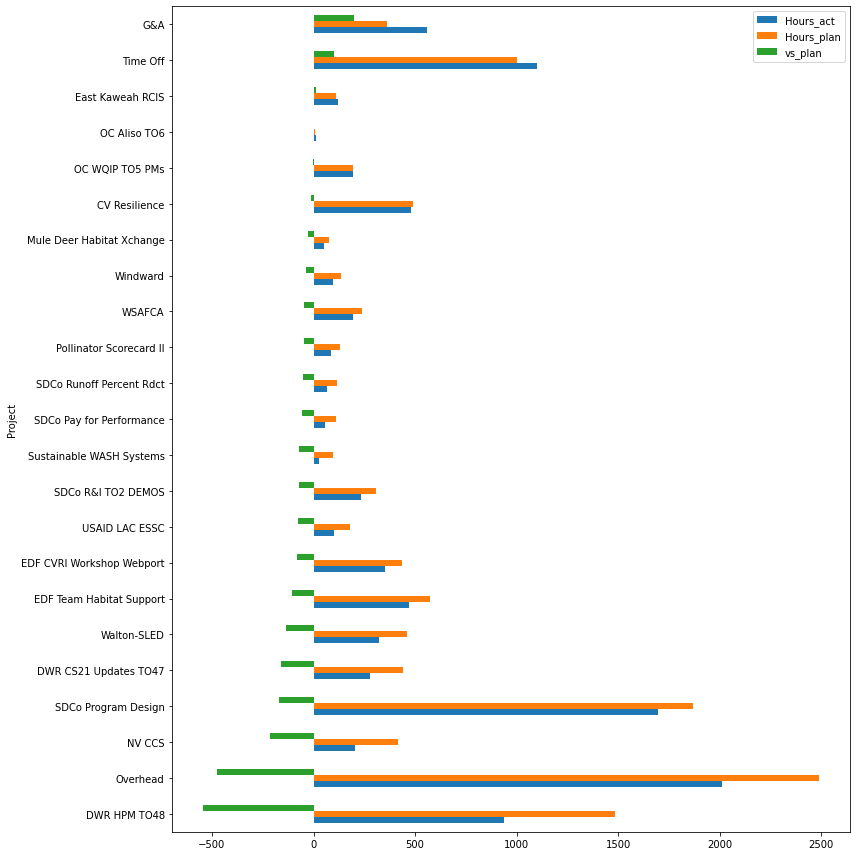

In [106]:
fig, ax = plt.subplots(figsize=(12,12))

planning.groupby('Project').sum().sort_values('vs_plan')[['Hours_act', 'Hours_plan', 'vs_plan']].plot(kind='barh', ax=ax)

plt.tight_layout()
plt.show()

In [107]:
actual = hours_report.groupby(['Employee ID', 'Entry Year', 'Entry Month'])['Entered Hours'].sum()
plan = scoreboard.groupby(['Employee ID', 'Entry Year', 'Entry Month'])['Hours'].sum()
month_compare = pd.merge(actual, plan, left_index=True, right_index=True).reset_index()
filt = month_compare['Employee ID'].isin(portfolio_emp_dict['Habitat']+portfolio_emp_dict['Water'])
month_compare['vs_plan'] = month_compare['Entered Hours'] - month_compare['Hours']
month_compare_pivot = month_compare.loc[filt].pivot(index=['Entry Year', 'Entry Month'], columns='Employee ID', values='vs_plan')
month_compare_pivot

Employee ID             100022.0  100023.0  100026.0  100030.0  100045.0  \
Entry Year Entry Month                                                     
2020       Apr             -3.67     -3.85    -17.49     21.25     -2.42   
           Aug            -22.88      6.00      2.05     50.75      0.91   
           Dec            -11.96     -9.25    -32.95     16.75      3.55   
           Feb            -12.87      4.84    -28.96     -5.00     17.21   
           Jan             -8.03     65.31     32.77     71.75     35.75   
           Jul             -9.30     -7.35    -10.91      1.00     13.53   
           Jun            -22.52    -17.50     19.71     10.00    -10.15   
           Mar            -24.37     -3.13    -31.29    -16.00    -25.90   
           May            -14.32     -3.63      2.74    -12.75    -23.45   
           Nov            -44.30    -15.75    -42.71     -4.25    -18.85   
           Oct            -16.24      6.50      2.87     22.50      0.75   
           Sep            -10.33     -9.80    -23.59     19.50     -1.75   
2021       Jan            -23.06      0.50    -25.00     -6.00    -16.15   

Employee ID             100076.0  100077.0  
Entry Year Entry Month                      
2020       Apr               NaN       NaN  
           Aug              9.95      0.50  
           Dec             -4.23     -0.50  
           Feb               NaN       NaN  
           Jan               NaN       NaN  
           Jul            -20.09      4.95  
           Jun            -19.39     36.00  
           Mar               NaN       NaN  
           May               NaN       NaN  
           Nov             15.36     -9.75  
           Oct              0.85     -3.70  
           Sep              3.42      6.70  
2021       Jan            -16.50    -42.50

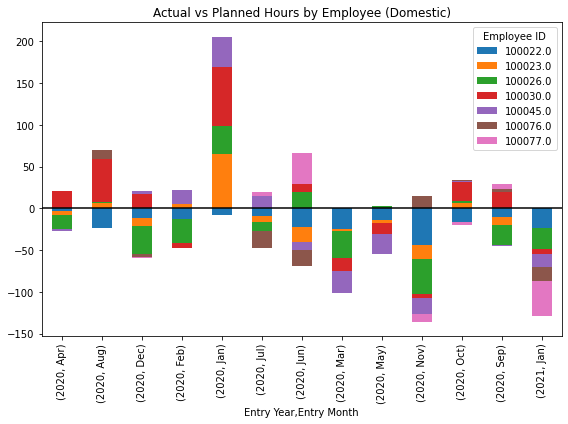

In [108]:
fig, ax = plt.subplots(figsize=(8,6))
month_compare_pivot.plot(kind='bar', stacked=True, ax=ax, title='Actual vs Planned Hours by Employee (Domestic)')
plt.tight_layout()
ax.axhline(0, color='black')
# ax.get_legend().remove()
plt.show()

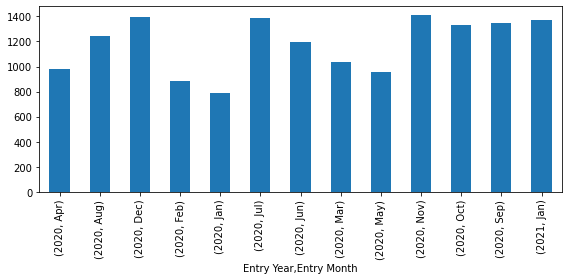

In [109]:
fig, ax = plt.subplots(figsize=(8,4))
scoreboard.groupby(['Entry Year', 'Entry Month'])['Hours'].sum().plot(kind='bar')
plt.tight_layout()
# ax.get_legend().remove()
plt.show()

### Potential takeaways
* The expectation of 110% is greater than we actually work (esp. non-partners) and may be fueling anxiety unnecessarily
* At least Domestic consistently over plans when targetting 110%+
* Project start-up can lead to extreme over-working for staff involved with that project
* Domestic tends to work most closely to the company average (107%) over the long term.

### Potential actions
* Re-set the expectation for 105% FTE
* Recognize the difference between Domestic and International projects
* Find ways of mitigating start-up burn out (PCM, Africa, CH in 2020)